Load Data

In [1]:
!pip install vaderSentiment
!pip install scikit-surprise
!pip install folium
!pip install surprise

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2457389 sha256=8592ac91afeaf87b3f4e35807b3759466a0dde8546a79ce51b39a93d6cbb1fd1
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [3]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import warnings

# sklearn ML tools
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RepeatedKFold, train_test_split as sklearn_train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# Advanced ML
import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMRegressor

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Sentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Recommendation system
#from surprise import Reader, Dataset, SVD, accuracy, BaselineOnly, SlopeOne
from surprise.model_selection import train_test_split, GridSearchCV, cross_validate

# Utilities
import joblib
import random

# Plotting config
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
# load the datasets
# load listings
reviews_df = pd.read_csv('reviews.csv.gz', compression='gzip')
reviews_df.head(3)

listing_id      id        date  reviewer_id         reviewer_name  \
0       44077  203703  2011-03-20       393348             Christian   
1       44077  211369  2011-03-28       444004               Solidea   
2       44077  234215  2011-04-21       465058  Michael And Isabelle   

                                            comments  
0  We enjoyed our stay very much. The room was co...  
1  We have been here 4 nights. Stay in a home is ...  
2  Teresa and Hughie were great hosts. They were ...

In [6]:
reviews_df.info(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310128 entries, 0 to 310127
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     310128 non-null  int64 
 1   id             310128 non-null  int64 
 2   date           310128 non-null  object
 3   reviewer_id    310128 non-null  int64 
 4   reviewer_name  310128 non-null  object
 5   comments       310100 non-null  object
dtypes: int64(3), object(3)
memory usage: 14.2+ MB


In [7]:
reviews_df.isna().sum()

listing_id        0
id                0
date              0
reviewer_id       0
reviewer_name     0
comments         28
dtype: int64

In [8]:
reviews_df.dropna(inplace=True)

In [9]:
# initialize vader Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

In [10]:
# feature engineer and introduce a new column sentiment score
reviews_df['compound_scores'] = reviews_df['comments'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
reviews_df.head(2)

listing_id      id        date  reviewer_id reviewer_name  \
0       44077  203703  2011-03-20       393348     Christian   
1       44077  211369  2011-03-28       444004       Solidea   

                                            comments  compound_scores  
0  We enjoyed our stay very much. The room was co...           0.9849  
1  We have been here 4 nights. Stay in a home is ...           0.9846

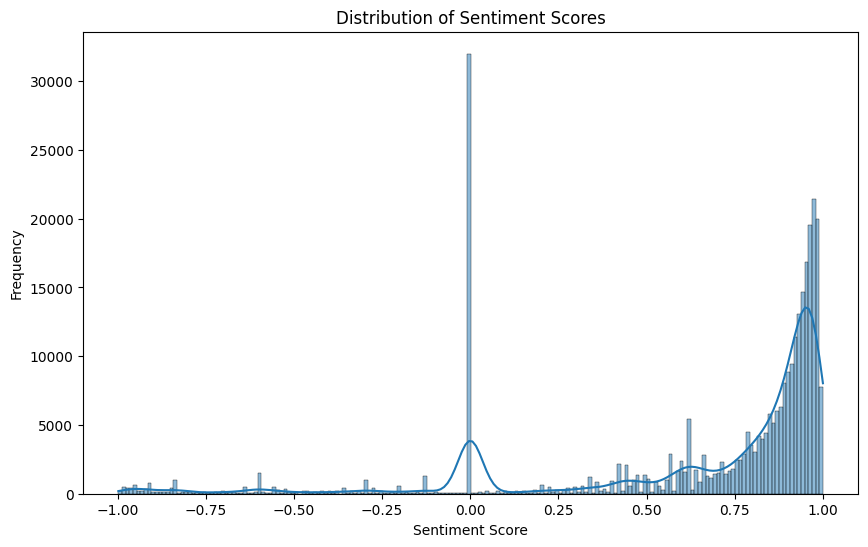

In [11]:
# check the distribution of sentiment scores
plt.figure(figsize=(10, 6))
sns.histplot(reviews_df['compound_scores'], kde=True)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

In [12]:
print(f"Total reviews: {len(reviews_df)}")

Total reviews: 310100


In [13]:
print(f"Unique listings with reviews: {reviews_df['listing_id'].nunique()}")

Unique listings with reviews: 5619


In [14]:
reviews_df['date'] = pd.to_datetime(reviews_df['date'])

<Axes: title={'center': 'Number of Reviews per Month'}, xlabel='date'>

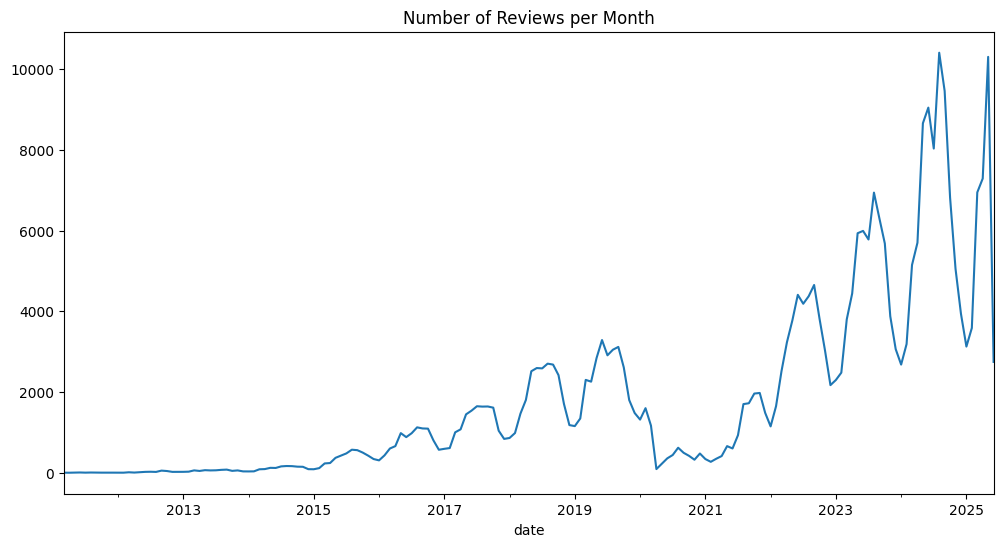

In [15]:
reviews_df.set_index('date', inplace=True)
monthly_reviews = reviews_df.resample('M').size()
monthly_reviews.plot(title='Number of Reviews per Month', figsize=(12,6))

In [16]:
reviews_per_listing = reviews_df.groupby('listing_id').size()
print(reviews_per_listing.describe())

count    5619.000000
mean       55.187756
std       100.611064
min         1.000000
25%         5.000000
50%        18.000000
75%        60.000000
max      1751.000000
dtype: float64


In [17]:
top_listings = reviews_per_listing.sort_values(ascending=False).head(10)
print(top_listings)

listing_id
46256758    1751
14941430    1081
46389088    1023
13689736     953
17688731     925
13759408     871
5656305      840
13787166     823
9730671      812
19546574     798
dtype: int64


In [18]:
reviews_per_reviewer = reviews_df.groupby('reviewer_id').size()
print(reviews_per_reviewer.describe())

count    285704.000000
mean          1.085389
std           0.526644
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          73.000000
dtype: float64


In [259]:
# load the datasets
# load listings
listings_df = pd.read_csv('listings (1).csv.gz', compression='gzip')
listings_df.head(3)

id                          listing_url       scrape_id last_scraped  \
0   44077   https://www.airbnb.com/rooms/44077  20250613040039   2025-06-13   
1   85156   https://www.airbnb.com/rooms/85156  20250613040039   2025-06-13   
2  159889  https://www.airbnb.com/rooms/159889  20250613040039   2025-06-13   

        source                                          name  \
0  city scrape           cosy comfortable Irish cottage twin   
1  city scrape  Cosy Comfortable Irish Cottage  1 Double Bed   
2  city scrape                          Friendly Single Room   

                                         description  \
0  Our house is a cosy comfortable cottage  with ...   
1  Our Cottage is a charming light filled cottage...   
2  Washing can be done at a cost of €5  per load....   

                               neighborhood_overview  \
0  I like our neighbourhood as there is no shorta...   
1  I love Dundrum and its surrounding areas ,<br ...   
2  Plenty of buses into the city and the area is ...   

                                         picture_url  host_id  \
0  https://a0.muscache.com/pictures/525706/050a3a...   193005   
1  https://a0.muscache.com/pictures/1749253/9ed2a...   193005   
2  https://a0.muscache.com/pictures/3031697/a8259...   766611   

                                   host_url host_name  host_since  \
0  https://www.airbnb.com/users/show/193005    Teresa  2010-08-06   
1  https://www.airbnb.com/users/show/193005    Teresa  2010-08-06   
2  https://www.airbnb.com/users/show/766611     Marie  2011-07-01   

             host_location                                         host_about  \
0          Dublin, Ireland  I am  a friendly outgoing Irishwoman ,who love...   
1          Dublin, Ireland  I am  a friendly outgoing Irishwoman ,who love...   
2  Dublin Airport, Ireland  Used to host students and now I  am looking fo...   

   host_response_time host_response_rate host_acceptance_rate  \
0  within a few hours               100%                  99%   
1  within a few hours               100%                  99%   
2  within a few hours               100%                  94%   

  host_is_superhost                                 host_thumbnail_url  \
0                 t  https://a0.muscache.com/im/pictures/user/2167f...   
1                 t  https://a0.muscache.com/im/pictures/user/2167f...   
2                 f  https://a0.muscache.com/im/pictures/user/5059e...   

                                    host_picture_url host_neighbourhood  \
0  https://a0.muscache.com/im/pictures/user/2167f...         Churchtown   
1  https://a0.muscache.com/im/pictures/user/2167f...         Churchtown   
2  https://a0.muscache.com/im/pictures/user/5059e...           Beaumont   

   host_listings_count  host_total_listings_count  host_verifications  \
0                  2.0                        2.0  ['email', 'phone']   
1                  2.0                        2.0  ['email', 'phone']   
2                  3.0                        3.0  ['email', 'phone']   

  host_has_profile_pic host_identity_verified        neighbourhood  \
0                    t                      t  Churchtown, Ireland   
1                    t                      t  Churchtown, Ireland   
2                    t                      t      Dublin, Ireland   

  neighbourhood_cleansed  neighbourhood_group_cleansed  latitude  longitude  \
0  Dn Laoghaire-Rathdown                           NaN  53.29178   -6.25792   
1  Dn Laoghaire-Rathdown                           NaN  53.29209   -6.25624   
2            Dublin City                           NaN  53.39027   -6.23547   

              property_type     room_type  accommodates  bathrooms  \
0  Private room in bungalow  Private room             2        1.0   
1  Private room in bungalow  Private room             2        1.5   
2      Private room in home  Private room             1        2.0   

   bathrooms_text  bedrooms  beds  \
0  1 private bath       1.0   2.0   
1       1.5 bat

In [260]:
pd.set_option('display.max_columns', None)  # Show all columns when printing

print(listings_df.head(3))

       id                          listing_url       scrape_id last_scraped  \
0   44077   https://www.airbnb.com/rooms/44077  20250613040039   2025-06-13   
1   85156   https://www.airbnb.com/rooms/85156  20250613040039   2025-06-13   
2  159889  https://www.airbnb.com/rooms/159889  20250613040039   2025-06-13   

        source                                          name  \
0  city scrape           cosy comfortable Irish cottage twin   
1  city scrape  Cosy Comfortable Irish Cottage  1 Double Bed   
2  city scrape                          Friendly Single Room   

                                         description  \
0  Our house is a cosy comfortable cottage  with ...   
1  Our Cottage is a charming light filled cottage...   
2  Washing can be done at a cost of €5  per load....   

                               neighborhood_overview  \
0  I like our neighbourhood as there is no shorta...   
1  I love Dundrum and its surrounding areas ,<br ...   
2  Plenty of buses into the city 

In [261]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6781 entries, 0 to 6780
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            6781 non-null   int64  
 1   listing_url                                   6781 non-null   object 
 2   scrape_id                                     6781 non-null   int64  
 3   last_scraped                                  6781 non-null   object 
 4   source                                        6781 non-null   object 
 5   name                                          6781 non-null   object 
 6   description                                   6640 non-null   object 
 7   neighborhood_overview                         2457 non-null   object 
 8   picture_url                                   6781 non-null   object 
 9   host_id                                       6781 non-null   i

In [262]:
# Clean price: remove $ and convert to float
listings_df['price'] = listings_df['price'].str.replace('[\$,]', '', regex=True).astype(float)

In [263]:
# Convert date columns to datetime
listings_df['first_review'] = pd.to_datetime(listings_df['first_review'], errors='coerce')
listings_df['last_review'] = pd.to_datetime(listings_df['last_review'], errors='coerce')
listings_df['host_since'] = pd.to_datetime(listings_df['host_since'], errors='coerce')

In [264]:
# Create time-based features
from datetime import datetime
today = pd.to_datetime('today')

listings_df['days_since_last_review'] = (today - listings_df['last_review']).dt.days
listings_df['host_tenure_days'] = (today - listings_df['host_since']).dt.days

In [265]:
# Fill NaNs for these features with some large number or median (decide based on exploration)
listings_df['days_since_last_review'] = listings_df['days_since_last_review'].fillna(9999)
listings_df['host_tenure_days'] = listings_df['host_tenure_days'].fillna(0)

In [266]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6781 entries, 0 to 6780
Data columns (total 81 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            6781 non-null   int64         
 1   listing_url                                   6781 non-null   object        
 2   scrape_id                                     6781 non-null   int64         
 3   last_scraped                                  6781 non-null   object        
 4   source                                        6781 non-null   object        
 5   name                                          6781 non-null   object        
 6   description                                   6640 non-null   object        
 7   neighborhood_overview                         2457 non-null   object        
 8   picture_url                                   6781 non-null   object

The initial step was to clean and preper the dataset to ensure consistency and usability for our analysis. Price firstconverted from the string format whih has the currency sign to numeric values so as to enable statistical calulations. Relivent data fields were set to datatime object, this is to creat features that influences listing perfromance.

Data Cleaning

In [267]:
listings_df.isna().sum()

id                                                 0
listing_url                                        0
scrape_id                                          0
last_scraped                                       0
source                                             0
                                                ... 
calculated_host_listings_count_private_rooms       0
calculated_host_listings_count_shared_rooms        0
reviews_per_month                               1162
days_since_last_review                             0
host_tenure_days                                   0
Length: 81, dtype: int64

In [268]:
missing_counts = listings_df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing_counts / len(listings_df)) * 100
missing_df = pd.concat([missing_counts, missing_percent], axis=1, keys=['Missing Count', 'Missing %'])
print(missing_df.head(20))

                              Missing Count   Missing %
neighbourhood_group_cleansed           6781  100.000000
calendar_updated                       6781  100.000000
license                                6781  100.000000
neighbourhood                          4324   63.766406
neighborhood_overview                  4324   63.766406
host_about                             4025   59.357027
host_location                          1781   26.264563
host_neighbourhood                     1467   21.633977
bathrooms                              1391   20.513199
beds                                   1388   20.468957
price                                  1386   20.439463
estimated_revenue_l365d                1386   20.439463
review_scores_rating                   1162   17.136116
review_scores_accuracy                 1162   17.136116
review_scores_cleanliness              1162   17.136116
last_review                            1162   17.136116
first_review                           1162   17

neighbourhood_group_cleansed, calendar_updated and license are empty with 100% missing values while, neighbourhood has 63.8% of its values missing, neighborhood_overview has 63.8% missing values and host_location has 59.4% missing values. based on this high percentage, we will be droping them.

In [269]:
# Drop columns with 100% missing values
listings_df = listings_df.drop(columns=['neighbourhood_group_cleansed', 'calendar_updated', 'license'])

In [270]:
# Drop 'neighbourhood' and 'neighborhood_overview' To keep a clean data
listings_df = listings_df.drop(columns=['neighbourhood', 'neighborhood_overview', 'host_about'])

Our target variable which is price, has 20.4% missing value and so drop only rows where price is missing.

In [271]:
# Drop rows where price is missing, since it's target variable
listings_df = listings_df.dropna(subset=['price'])

In [272]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5395 entries, 0 to 6780
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            5395 non-null   int64         
 1   listing_url                                   5395 non-null   object        
 2   scrape_id                                     5395 non-null   int64         
 3   last_scraped                                  5395 non-null   object        
 4   source                                        5395 non-null   object        
 5   name                                          5395 non-null   object        
 6   description                                   5276 non-null   object        
 7   picture_url                                   5395 non-null   object        
 8   host_id                                       5395 non-null   int64      

In [273]:
missing_counts = listings_df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing_counts / len(listings_df)) * 100
missing_df = pd.concat([missing_counts, missing_percent], axis=1, keys=['Missing Count', 'Missing %'])
print(missing_df.head(30))

                             Missing Count  Missing %
host_location                         1484  27.506951
host_neighbourhood                    1146  21.241891
review_scores_location                 931  17.256719
review_scores_value                    931  17.256719
last_review                            931  17.256719
review_scores_communication            931  17.256719
review_scores_checkin                  931  17.256719
review_scores_cleanliness              931  17.256719
review_scores_accuracy                 931  17.256719
review_scores_rating                   931  17.256719
reviews_per_month                      931  17.256719
first_review                           931  17.256719
host_response_rate                     455   8.433735
host_response_time                     455   8.433735
host_acceptance_rate                   247   4.578313
description                            119   2.205746
host_is_superhost                      114   2.113068
has_availability            

For our categorical variable, host-location and host_neighbourhood, we impute with Unkown this is to ensure that the dataset retains its structure without losing valuable rows, which could introduce bias or reduce sample size if removed.

In [274]:
# Fill missing categorical with 'Unknown'
listings_df['host_location'] = listings_df['host_location'].fillna('Unknown')
listings_df['host_neighbourhood'] = listings_df['host_neighbourhood'].fillna('Unknown')

Missing values in the bathrooms and beds columns were filled with the median. Using the median helps avoid the influence of outliers, keeping the data more balanced. This approach ensures that the overall distribution is preserved and prevents any extreme values from distorting the analysis.

In [275]:
# Fill numeric missing with median
listings_df['bathrooms'] = listings_df['bathrooms'].fillna(listings_df['bathrooms'].median())
listings_df['beds'] = listings_df['beds'].fillna(listings_df['beds'].median())

In [276]:
# First, ensure the 'price' column is a string type
listings_df['price'] = listings_df['price'].astype(str)

# Convert price to float after dropping NAs
listings_df['price'] = listings_df['price'].str.replace('[\$,]', '', regex=True).astype(float)


In [277]:
# Fill missing review scores with median
review_score_cols = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                     'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                     'review_scores_value']
for col in review_score_cols:
    listings_df[col] = listings_df[col].fillna(listings_df[col].median())

In [278]:
listings_df = listings_df.dropna(subset=['first_review', 'first_review'])

In [279]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4464 entries, 0 to 6728
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            4464 non-null   int64         
 1   listing_url                                   4464 non-null   object        
 2   scrape_id                                     4464 non-null   int64         
 3   last_scraped                                  4464 non-null   object        
 4   source                                        4464 non-null   object        
 5   name                                          4464 non-null   object        
 6   description                                   4408 non-null   object        
 7   picture_url                                   4464 non-null   object        
 8   host_id                                       4464 non-null   int64      

In [280]:
missing_counts = listings_df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing_counts / len(listings_df)) * 100
missing_df = pd.concat([missing_counts, missing_percent], axis=1, keys=['Missing Count', 'Missing %'])
print(missing_df.head(30))

                           Missing Count  Missing %
host_response_rate                   282   6.317204
host_response_time                   282   6.317204
host_is_superhost                    109   2.441756
host_acceptance_rate                  98   2.195341
description                           56   1.254480
bedrooms                              16   0.358423
bathrooms_text                         8   0.179211
host_since                             2   0.044803
host_thumbnail_url                     2   0.044803
host_name                              2   0.044803
host_identity_verified                 2   0.044803
host_picture_url                       2   0.044803
host_total_listings_count              2   0.044803
host_verifications                     2   0.044803
host_has_profile_pic                   2   0.044803
host_listings_count                    2   0.044803
host_url                               0   0.000000
listing_url                            0   0.000000
scrape_id   

In [281]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4464 entries, 0 to 6728
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            4464 non-null   int64         
 1   listing_url                                   4464 non-null   object        
 2   scrape_id                                     4464 non-null   int64         
 3   last_scraped                                  4464 non-null   object        
 4   source                                        4464 non-null   object        
 5   name                                          4464 non-null   object        
 6   description                                   4408 non-null   object        
 7   picture_url                                   4464 non-null   object        
 8   host_id                                       4464 non-null   int64      

In [282]:
listings_df.dropna(inplace=True)

In [283]:
missing_counts = listings_df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing_counts / len(listings_df)) * 100
missing_df = pd.concat([missing_counts, missing_percent], axis=1, keys=['Missing Count', 'Missing %'])
print(missing_df.head(20))

                      Missing Count  Missing %
id                                0        0.0
listing_url                       0        0.0
scrape_id                         0        0.0
last_scraped                      0        0.0
source                            0        0.0
name                              0        0.0
description                       0        0.0
picture_url                       0        0.0
host_id                           0        0.0
host_url                          0        0.0
host_name                         0        0.0
host_since                        0        0.0
host_location                     0        0.0
host_response_time                0        0.0
host_response_rate                0        0.0
host_acceptance_rate              0        0.0
host_is_superhost                 0        0.0
host_thumbnail_url                0        0.0
host_picture_url                  0        0.0
host_neighbourhood                0        0.0


In [284]:
listings_df.shape

(4007, 75)

Columns with no available data were removed to maintain dataset quality. Features with significant missingness, such as ‘neighbourhood’ and ‘host_about’, were excluded due to the potential bias they could introduce. Missing values in numeric columns like bathrooms and beds were imputed with median values to preserve central tendency without skewing distributions. Categorical features such as host location were assigned an 'Unknown' category to retain listings without that information. Review-related features with missing values were filled with medians or placeholder dates, reflecting the absence of reviews. Listings missing the target variable, price, were excluded from analysis to ensure model training validity.

Exploratory Data Analysis

In [285]:
# Descriptive statistics for key numeric variables
print(listings_df[['price', 'accommodates', 'bedrooms', 'bathrooms', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']].describe())

              price  accommodates     bedrooms    bathrooms  \
count   4007.000000   4007.000000  4007.000000  4007.000000   
mean     183.475168      3.259795     1.542800     1.335413   
std      270.243799      2.115756     0.979369     0.706613   
min       20.000000      1.000000     0.000000     0.000000   
25%       85.000000      2.000000     1.000000     1.000000   
50%      131.000000      2.000000     1.000000     1.000000   
75%      221.000000      4.000000     2.000000     1.500000   
max    12299.000000     16.000000    17.000000     9.000000   

       review_scores_rating  review_scores_accuracy  \
count           4007.000000             4007.000000   
mean               4.735435                4.772104   
std                0.409395                0.388762   
min                1.000000                1.000000   
25%                4.670000                4.730000   
50%                4.850000                4.880000   
75%                4.970000                4.98

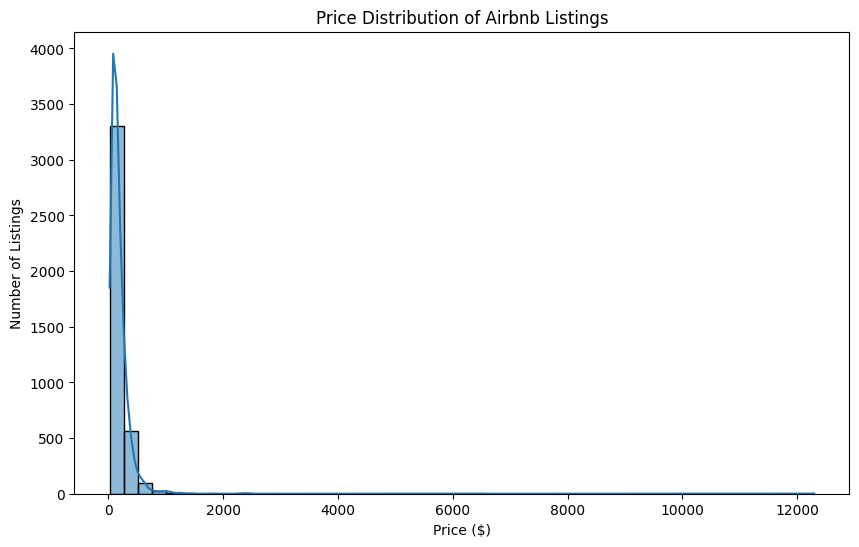

In [286]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(listings_df['price'], bins=50, kde=True)
plt.title('Price Distribution of Airbnb Listings')
plt.xlabel('Price ($)')
plt.ylabel('Number of Listings')
plt.show()


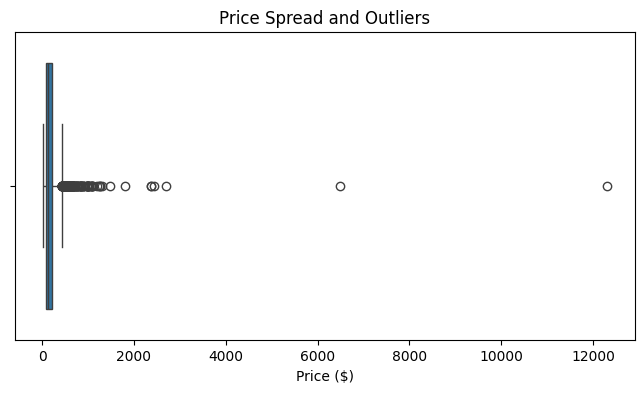

In [287]:
plt.figure(figsize=(8,4))
sns.boxplot(x=listings_df['price'])
plt.title('Price Spread and Outliers')
plt.xlabel('Price ($)')
plt.show()

We can see there are very few outliers, and so we decide to remove the top 1% outlier so see if the skewness would reduce.

In [288]:
price_threshold = listings_df['price'].quantile(0.99)
filtered_prices = listings_df[listings_df['price'] <= price_threshold]['price']

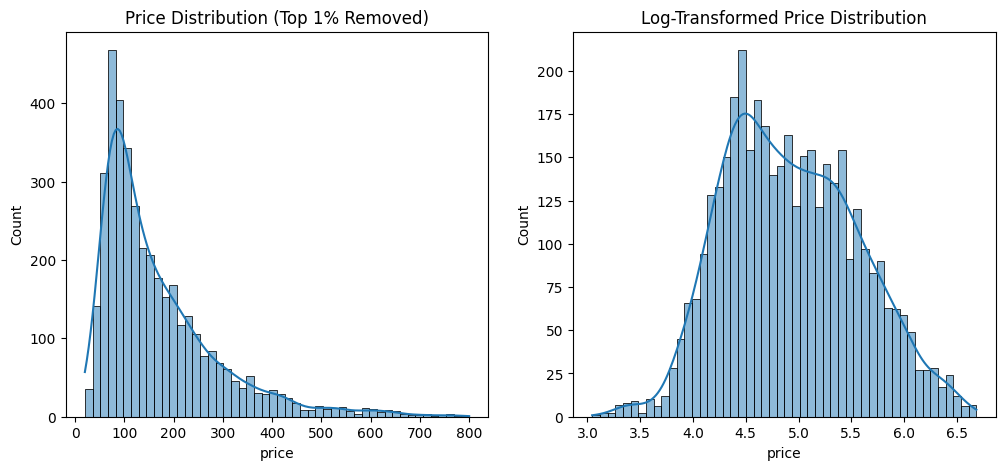

In [289]:
import numpy as np

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
sns.histplot(filtered_prices, bins=50, kde=True)
plt.title('Price Distribution (Top 1% Removed)')

plt.subplot(1, 2, 2)
sns.histplot(np.log1p(filtered_prices), bins=50, kde=True)
plt.title('Log-Transformed Price Distribution')

plt.show()


We can see that after removing the top 1% outlier, the price variable is still skewed, but after a successful log transformation, he price became normal, which is good for modelig as agaont the raw price variable and the one percent removed price.

Distribution of listings by room.

In [290]:
# Distribution of listings by room type
print(listings_df['room_type'].value_counts())

room_type
Entire home/apt    2218
Private room       1741
Shared room          44
Hotel room            4
Name: count, dtype: int64


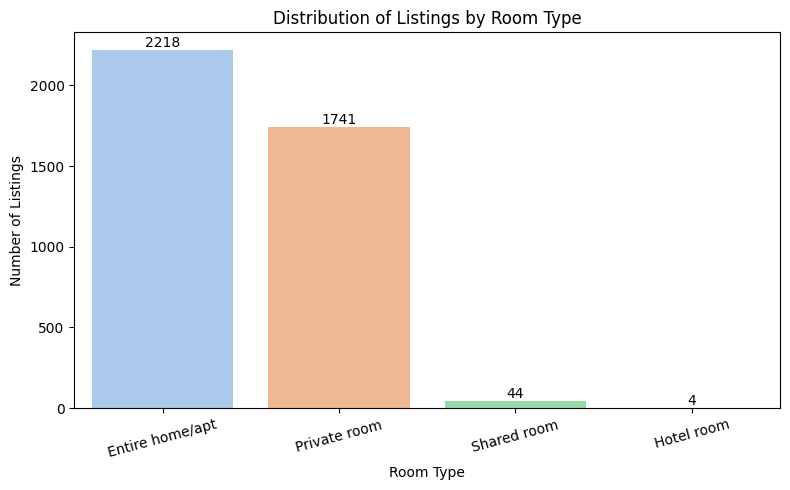

In [291]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))

# Create the plot
ax = sns.countplot(
    data=listings_df,
    x='room_type',
    order=listings_df['room_type'].value_counts().index,
    palette='pastel'
)
# Add counts on top of each bar
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(
        str(count),
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center',
        va='bottom',
        fontsize=10
    )
# Labels and title
plt.title('Distribution of Listings by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Number of Listings')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


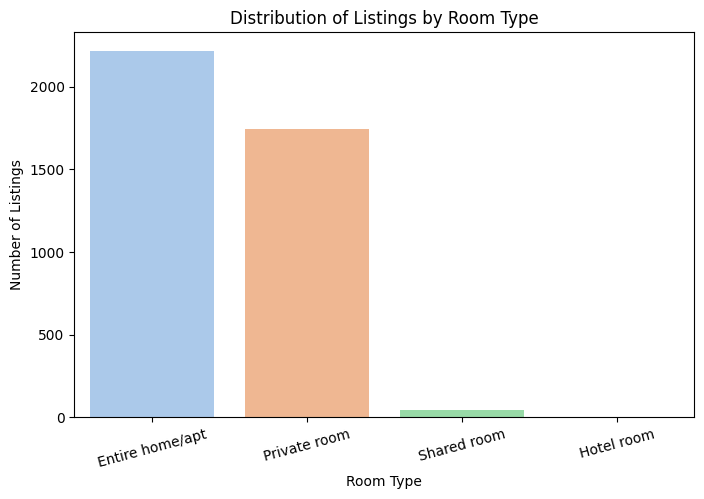

In [292]:
plt.figure(figsize=(8,5))
sns.countplot(data=listings_df, x='room_type', order=listings_df['room_type'].value_counts().index, palette='pastel')
plt.title('Distribution of Listings by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Number of Listings')
plt.xticks(rotation=15)
plt.show()

Most guests are likely looking for full privacy or at least their own private space. For hosts, focusing on entire homes or private rooms might attract the majority of travelers

In [293]:
# Top 10 property types by count
print(listings_df['property_type'].value_counts().head(10))

property_type
Entire rental unit                   943
Private room in home                 906
Entire home                          647
Private room in rental unit          357
Entire condo                         328
Private room in condo                209
Private room in townhouse            106
Entire townhouse                      74
Private room in bed and breakfast     60
Entire guesthouse                     42
Name: count, dtype: int64


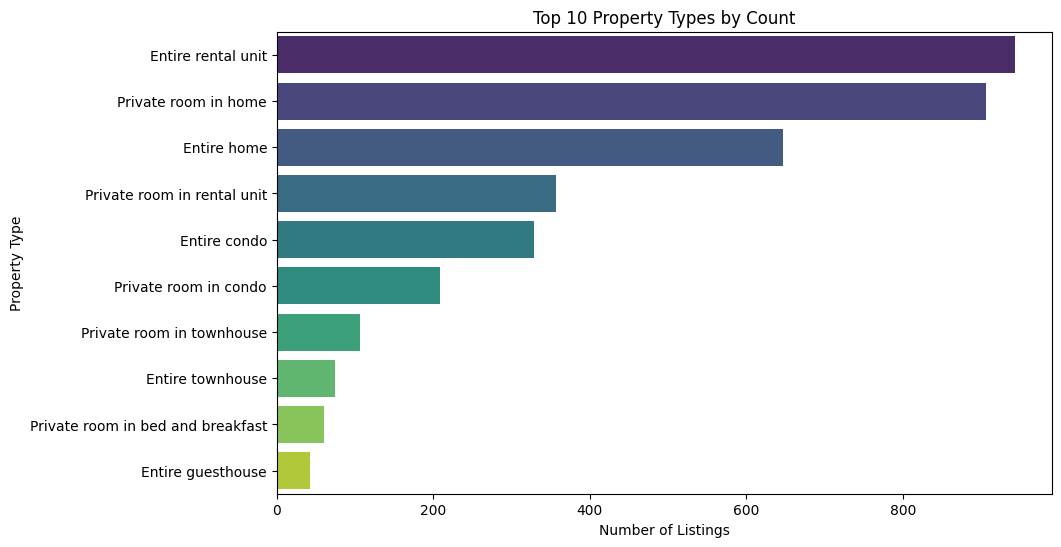

In [294]:
top10_property_types = listings_df['property_type'].value_counts().head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top10_property_types.values, y=top10_property_types.index, palette='viridis')
plt.title('Top 10 Property Types by Count')
plt.xlabel('Number of Listings')
plt.ylabel('Property Type')
plt.show()

This still suggest that host still prefers to list out their entire rental unit because the most common property type is Entire rental unit (943 listings), closely followed by Private room in home (906) and Entire home (647). Whole properties (entire units, homes, condos, townhouses) dominate, but there’s still a strong presence of private rooms in various types of residences.

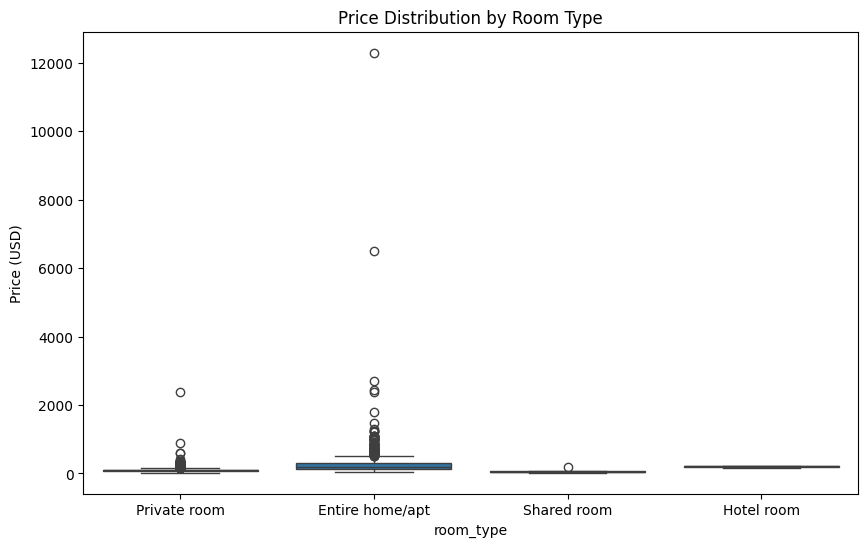

In [295]:
# Price by room type boxplot
plt.figure(figsize=(10,6))
sns.boxplot(x='room_type', y='price', data=listings_df)
plt.title('Price Distribution by Room Type')
plt.ylabel('Price (USD)')
plt.show()

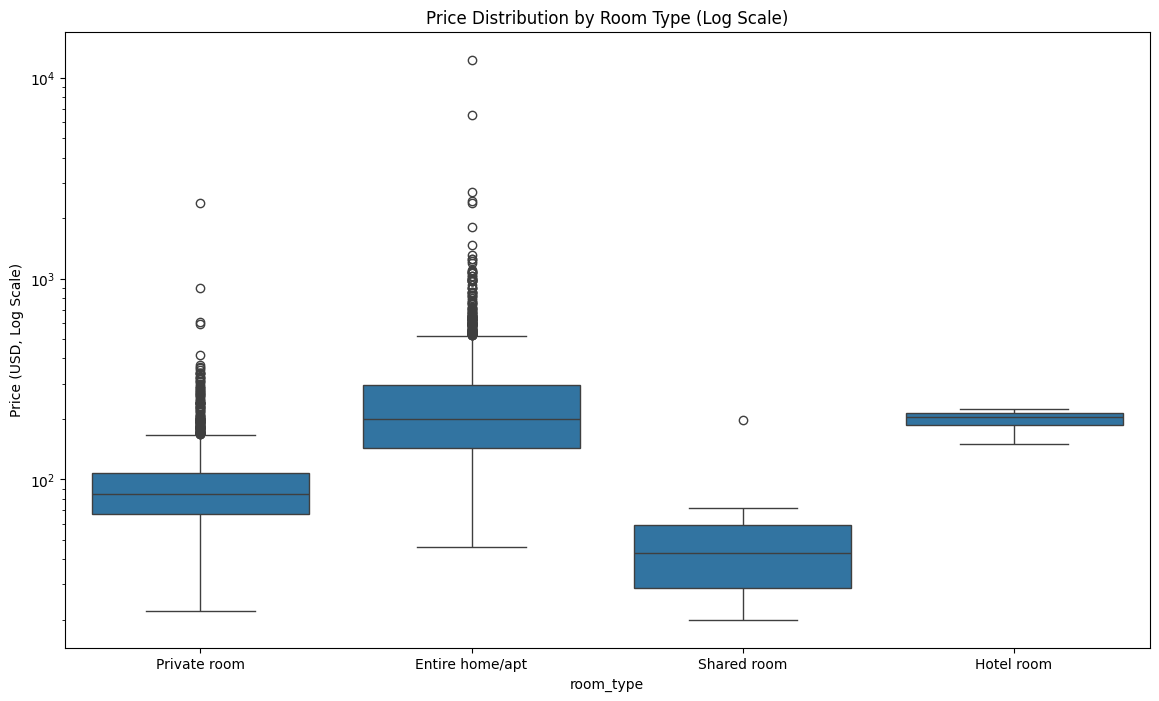

In [296]:
plt.figure(figsize=(14,8))
sns.boxplot(x='room_type', y='price', data=listings_df)
plt.yscale('log')  # Log scale for y-axis
plt.title('Price Distribution by Room Type (Log Scale)')
plt.ylabel('Price (USD, Log Scale)')
plt.show()


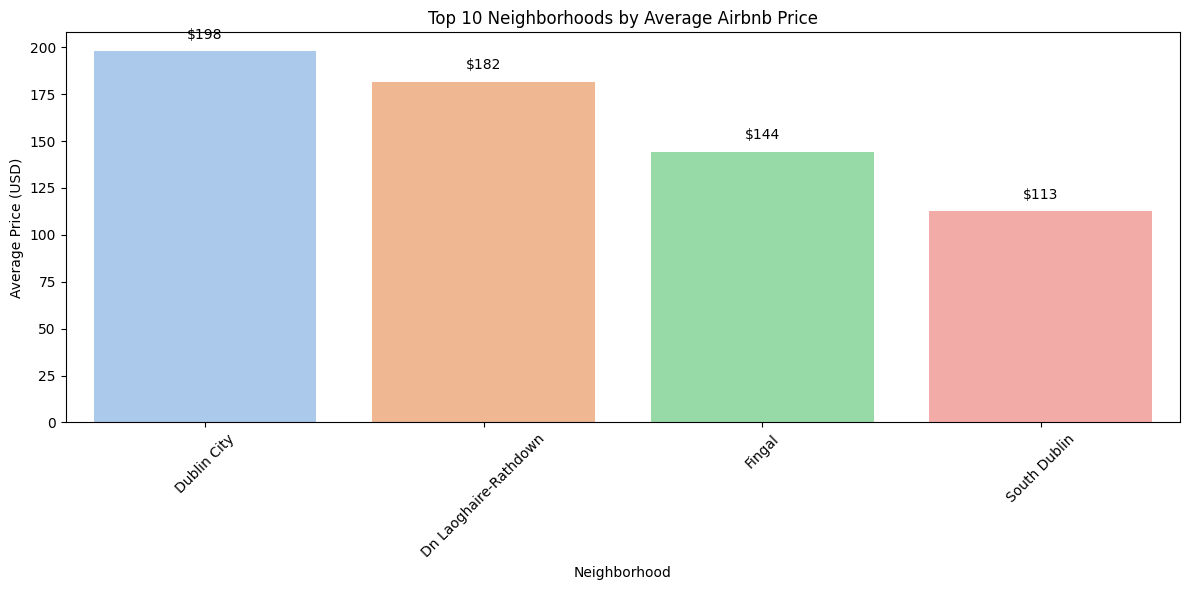

In [297]:
# Compute top 10 neighborhoods by average price
avg_price_neighborhood = listings_df.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x=avg_price_neighborhood.index,
    y=avg_price_neighborhood.values,
    palette='pastel'
)

# Add value labels on top of bars
for i, value in enumerate(avg_price_neighborhood.values):
    ax.text(
        i,                   # x-position
        value + 5,           # y-position slightly above the bar
        f"${value:.0f}",     # format to nearest dollar
        ha='center',
        va='bottom',
        fontsize=10
    )

# Titles and labels
plt.title('Top 10 Neighborhoods by Average Airbnb Price')
plt.ylabel('Average Price (USD)')
plt.xlabel('Neighborhood')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

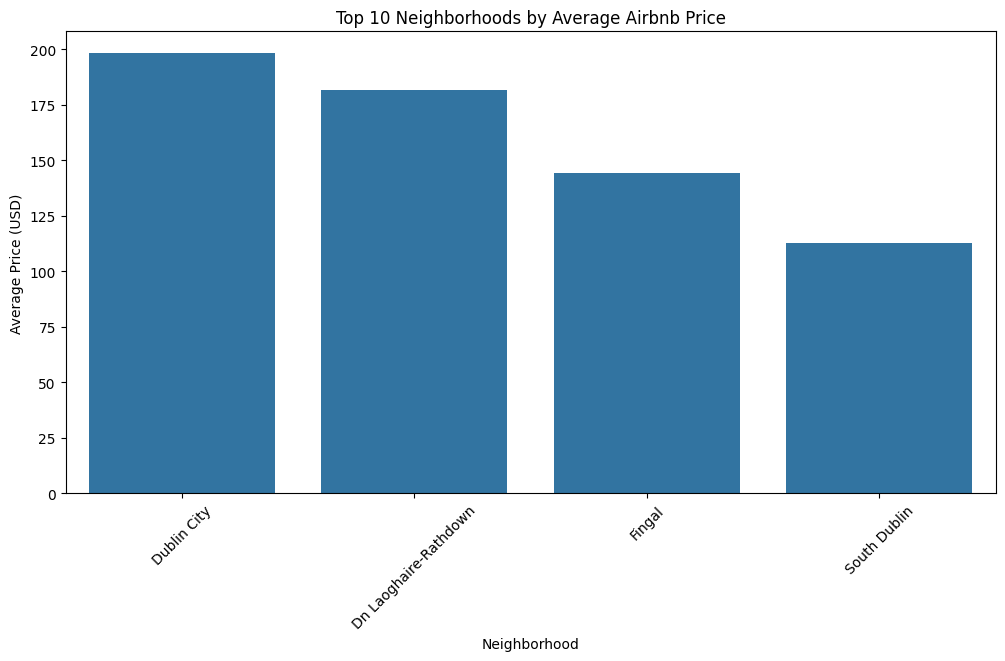

In [298]:
# Average price by neighborhood (top 10)
avg_price_neighborhood = listings_df.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=avg_price_neighborhood.index, y=avg_price_neighborhood.values)
plt.title('Top 10 Neighborhoods by Average Airbnb Price')
plt.ylabel('Average Price (USD)')
plt.xlabel('Neighborhood')
plt.xticks(rotation=45)
plt.show()

Dublin City commands the highest average price, around 199 USD, likely due to its central location, proximity to major attractions, and higher demand. Dn Laoghaire-Rathdown and Fingal also show relatively high average prices (182 USD and 145 USD respectively), indicating these areas may offer premium properties or desirable amenities attracting higher-paying guests. Conversely, neighborhoods like South Dublin have lower average prices (around 113 USD), which could suggest less demand, more budget-friendly options, or a different mix of property types.

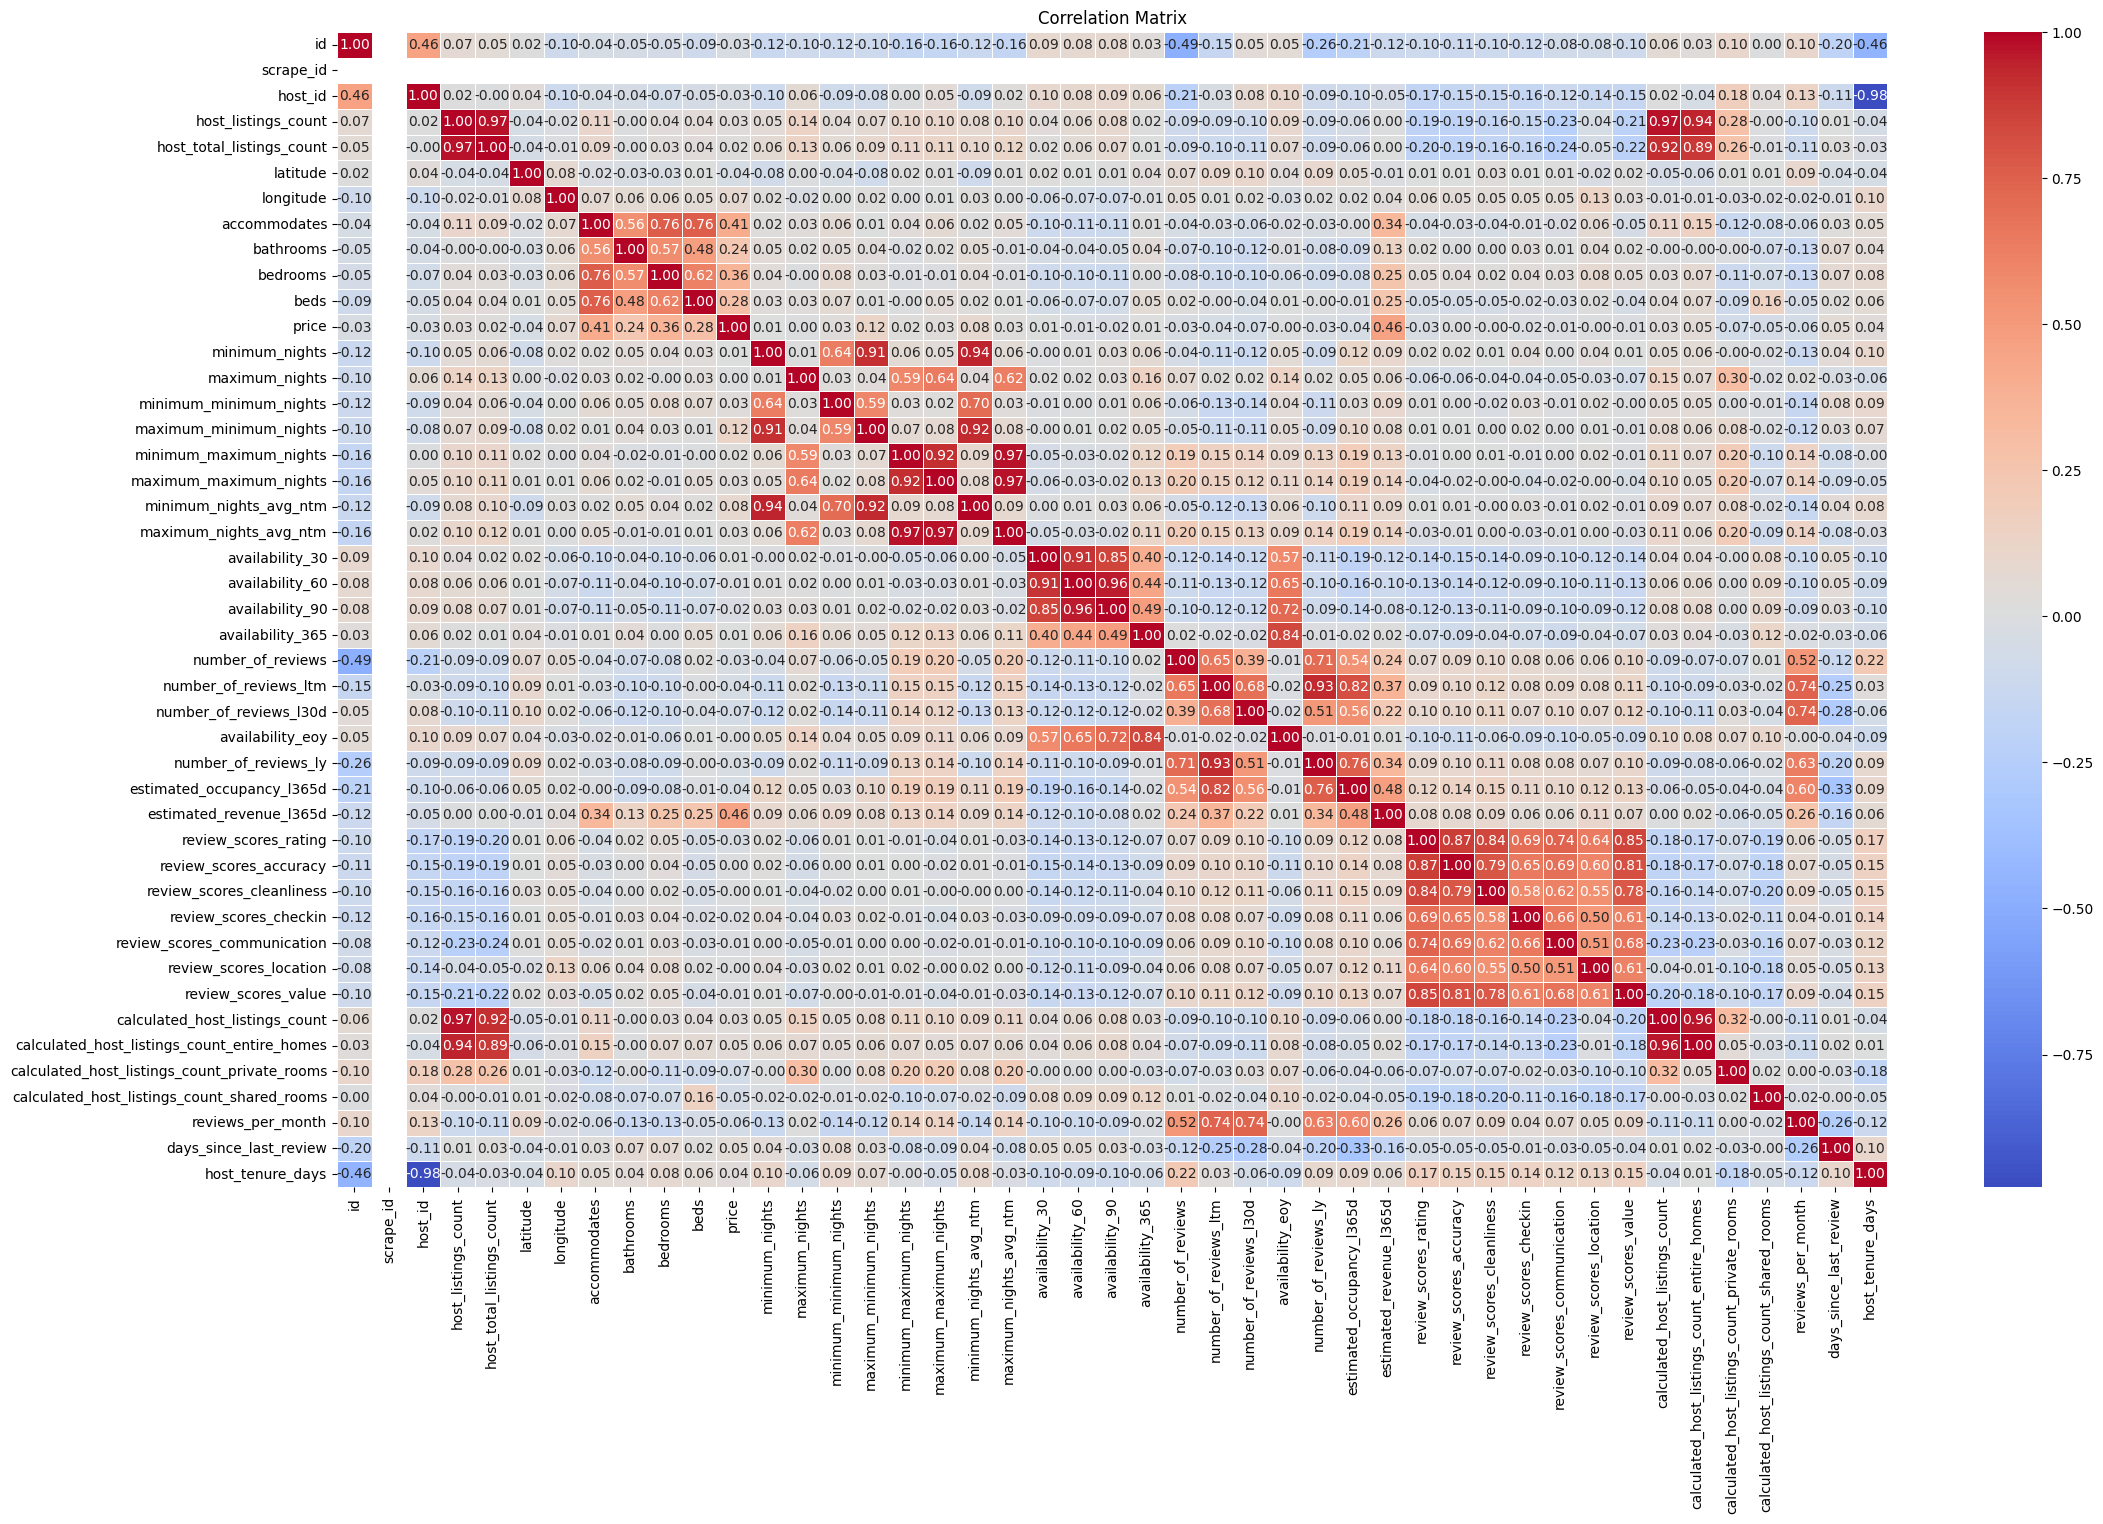

In [299]:
# Filter the dataframe to select only numeric columns
numeric_df = listings_df.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(25, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [300]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4007 entries, 0 to 6728
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            4007 non-null   int64         
 1   listing_url                                   4007 non-null   object        
 2   scrape_id                                     4007 non-null   int64         
 3   last_scraped                                  4007 non-null   object        
 4   source                                        4007 non-null   object        
 5   name                                          4007 non-null   object        
 6   description                                   4007 non-null   object        
 7   picture_url                                   4007 non-null   object        
 8   host_id                                       4007 non-null   int64      

**This ranks neighborhoods by how clean guests perceive the listings to be.**

In [301]:
# Group by more granular neighborhood
neighborhood_reviews = listings_df.groupby('neighbourhood_cleansed').agg({
    'review_scores_rating': 'mean',
    'review_scores_location': 'mean',
    'review_scores_cleanliness': 'mean',
    'review_scores_communication': 'mean',
    'review_scores_value': 'mean',
    'latitude': 'mean',
    'longitude': 'mean'
}).reset_index()

# Drop NA ratings
neighborhood_reviews = neighborhood_reviews.dropna(subset=['review_scores_cleanliness'])

# Sort by average rating
neighborhood_reviews = neighborhood_reviews.sort_values('review_scores_cleanliness', ascending=False)

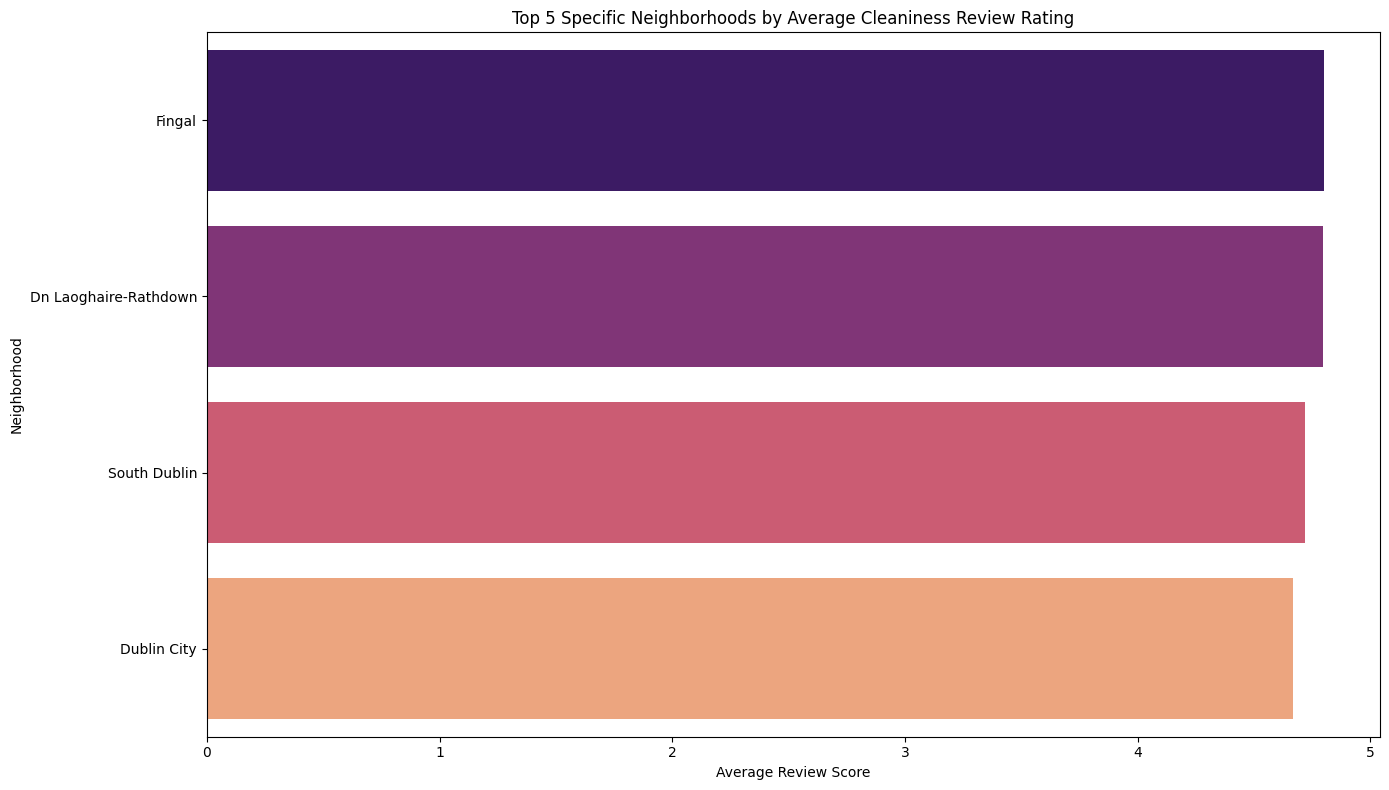

In [302]:
plt.figure(figsize=(14, 8))
sns.barplot(data=neighborhood_reviews.head(5),
            x='review_scores_cleanliness', y='neighbourhood_cleansed', palette='magma')
plt.title('Top 5 Specific Neighborhoods by Average Cleaniness Review Rating')
plt.xlabel('Average Review Score')
plt.ylabel('Neighborhood')
plt.tight_layout()
plt.show()

**This ranks neighborhoods by guests love for the location**

In [303]:
# Group by more granular neighborhood
neighborhood_reviews = listings_df.groupby('neighbourhood_cleansed').agg({
    'review_scores_rating': 'mean',
    'review_scores_location': 'mean',
    'review_scores_cleanliness': 'mean',
    'review_scores_communication': 'mean',
    'review_scores_value': 'mean',
    'latitude': 'mean',
    'longitude': 'mean'
}).reset_index()

# Drop NA ratings
neighborhood_reviews = neighborhood_reviews.dropna(subset=['review_scores_location'])

# Sort by average rating
neighborhood_reviews = neighborhood_reviews.sort_values('review_scores_location', ascending=False)

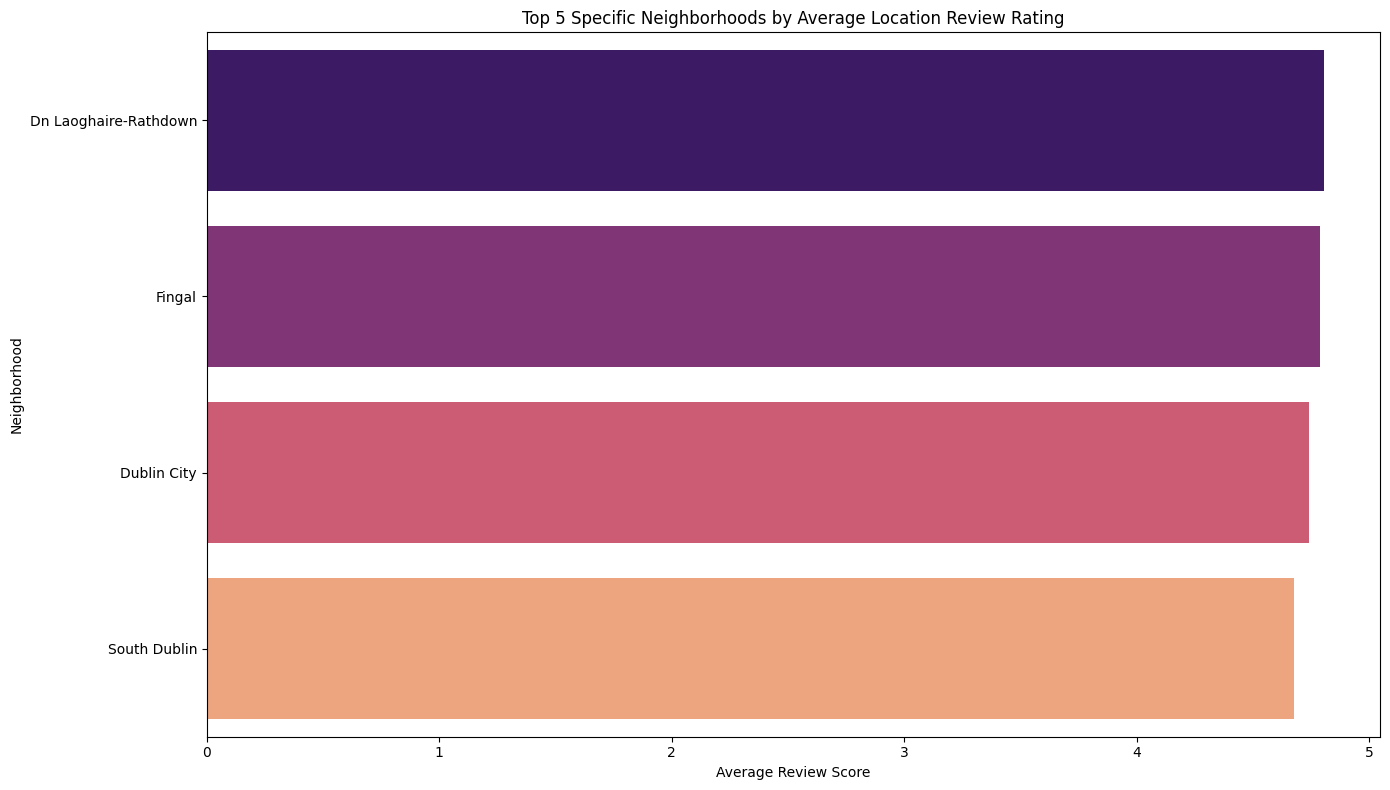

In [304]:
plt.figure(figsize=(14, 8))
sns.barplot(data=neighborhood_reviews.head(5),
            x='review_scores_location', y='neighbourhood_cleansed', palette='magma')
plt.title('Top 5 Specific Neighborhoods by Average Location Review Rating')
plt.xlabel('Average Review Score')
plt.ylabel('Neighborhood')
plt.tight_layout()
plt.show()

**This ranks neighborhoods by guests satisfaction with communication.**

In [305]:
# Group by more granular neighborhood
neighborhood_reviews = listings_df.groupby('neighbourhood_cleansed').agg({
    'review_scores_rating': 'mean',
    'review_scores_location': 'mean',
    'review_scores_cleanliness': 'mean',
    'review_scores_communication': 'mean',
    'review_scores_value': 'mean',
    'latitude': 'mean',
    'longitude': 'mean'
}).reset_index()

# Drop NA ratings
neighborhood_reviews = neighborhood_reviews.dropna(subset=['review_scores_communication'])

# Sort by average rating
neighborhood_reviews = neighborhood_reviews.sort_values('review_scores_communication', ascending=False)

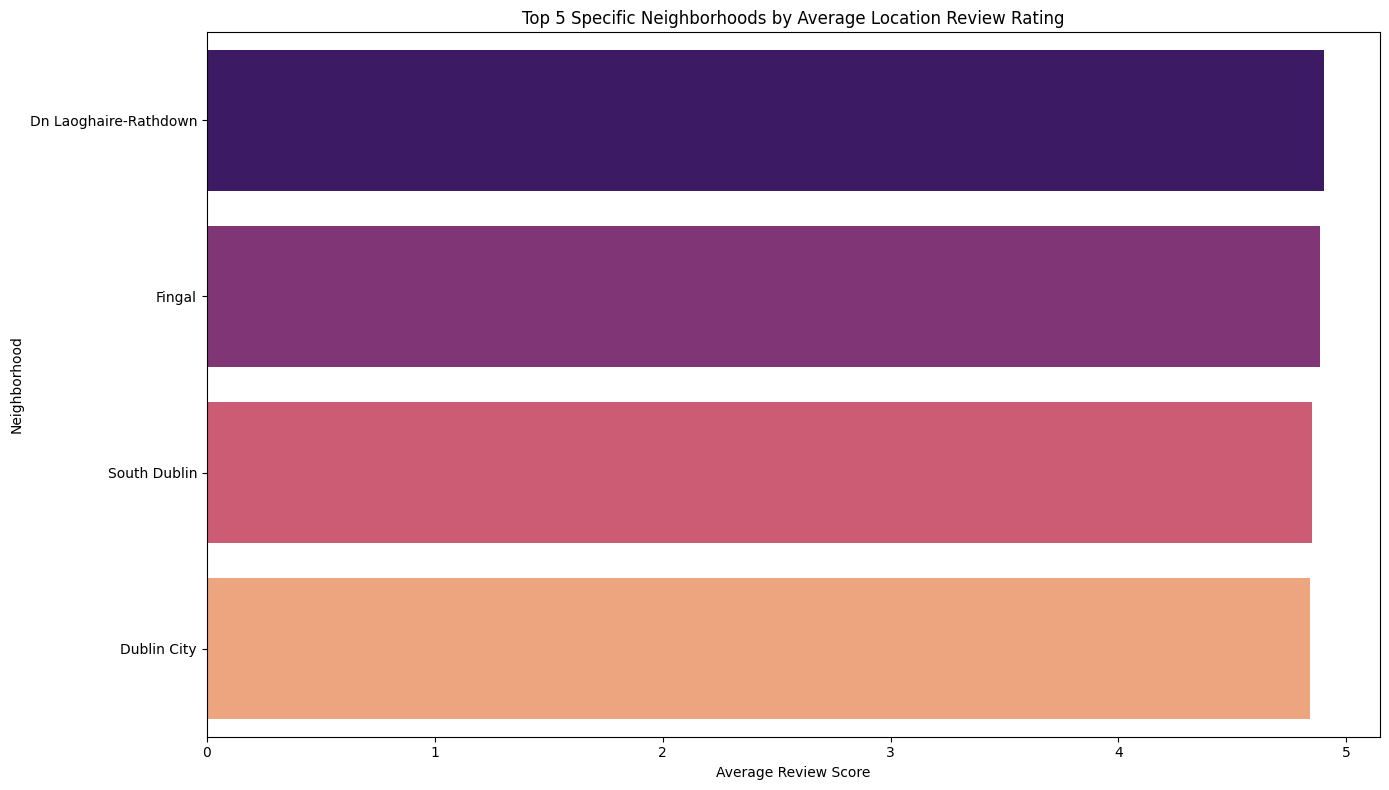

In [306]:
plt.figure(figsize=(14, 8))
sns.barplot(data=neighborhood_reviews.head(5),
            x='review_scores_communication', y='neighbourhood_cleansed', palette='magma')
plt.title('Top 5 Specific Neighborhoods by Average Location Review Rating')
plt.xlabel('Average Review Score')
plt.ylabel('Neighborhood')
plt.tight_layout()
plt.show()

**This ranks neighborhoods by general guest satisfaction.**

In [307]:
# Group by more granular neighborhood
neighborhood_reviews = listings_df.groupby('neighbourhood_cleansed').agg({
    'review_scores_rating': 'mean',
    'review_scores_location': 'mean',
    'review_scores_cleanliness': 'mean',
    'review_scores_communication': 'mean',
    'review_scores_value': 'mean',
    'latitude': 'mean',
    'longitude': 'mean'
}).reset_index()

# Drop NA ratings
neighborhood_reviews = neighborhood_reviews.dropna(subset=['review_scores_rating'])

# Sort by average rating
neighborhood_reviews = neighborhood_reviews.sort_values('review_scores_rating', ascending=False)

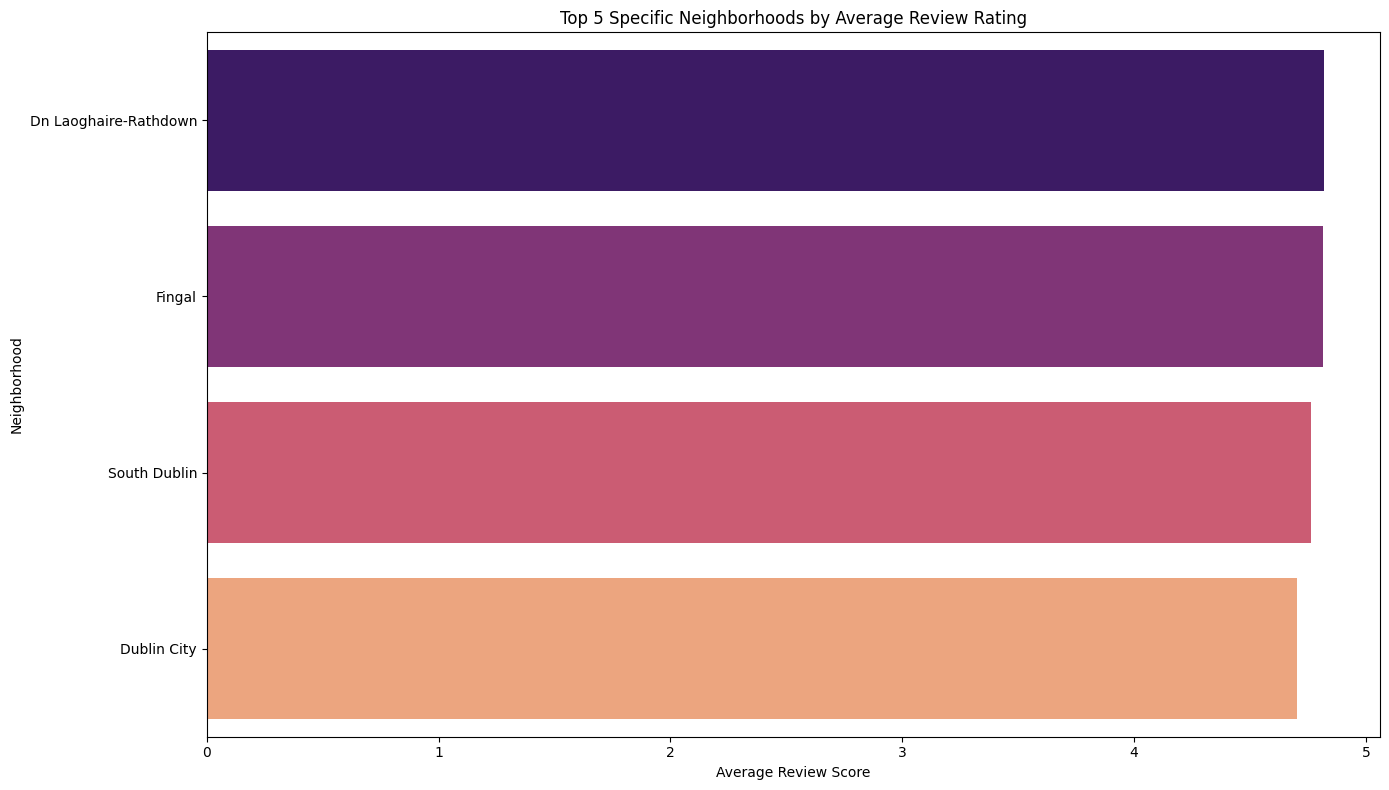

In [308]:
plt.figure(figsize=(14, 8))
sns.barplot(data=neighborhood_reviews.head(5),
            x='review_scores_rating', y='neighbourhood_cleansed', palette='magma')
plt.title('Top 5 Specific Neighborhoods by Average Review Rating')
plt.xlabel('Average Review Score')
plt.ylabel('Neighborhood')
plt.tight_layout()
plt.show()

In [309]:
import folium
from folium.plugins import MarkerCluster

# Initialize map centered on Dublin
dublin_map = folium.Map(location=[53.3498, -6.2603], zoom_start=12)

# Add markers with review scores
marker_cluster = MarkerCluster().add_to(dublin_map)

for i, row in neighborhood_reviews.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=6,
        popup=f"{row['neighbourhood_cleansed']}<br>Rating: {row['review_scores_rating']:.2f}",
        color='blue',
        fill=True,
        fill_opacity=0.7
    ).add_to(marker_cluster)

# Save or display
#dublin_map.save("dublin_airbnb_reviews_map.html")
display(dublin_map)


In [310]:
import folium
from folium.plugins import HeatMap
from folium.features import DivIcon

# Clean data
price_data = listings_df[['latitude', 'longitude', 'price']].dropna()

# Optional: reduce size for performance
price_data = price_data.sample(n=300, random_state=1)  # remove this if you want all

# Create base map
m = folium.Map(location=[price_data['latitude'].mean(), price_data['longitude'].mean()], zoom_start=12)

# Add HeatMap layer
heat_data = [[row['latitude'], row['longitude'], row['price']] for idx, row in price_data.iterrows()]
HeatMap(heat_data, radius=15, max_zoom=13).add_to(m)

# Add price labels directly on the map using DivIcon
for idx, row in price_data.iterrows():
    folium.map.Marker(
        [row['latitude'], row['longitude']],
        icon=DivIcon(
            icon_size=(100, 24),
            icon_anchor=(0, 0),
            html=f'<div style="font-size:10px; color:black;">${row["price"]:.0f}</div>',
        )
    ).add_to(m)

# Display map
m


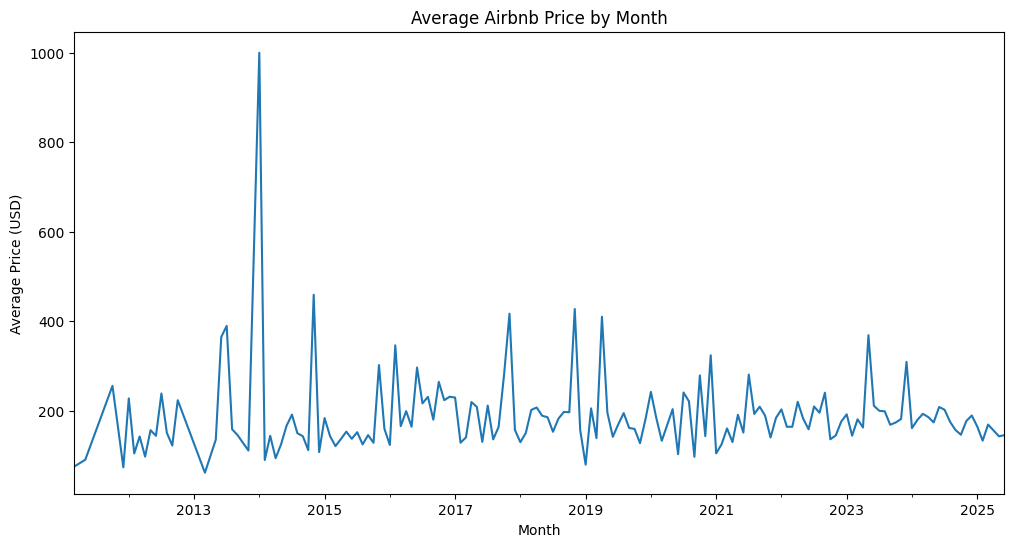

In [311]:
# Extract month-year from review date
listings_df['review_month'] = listings_df['first_review'].dt.to_period('M')

# Group by month and calculate average price
monthly_avg_price = listings_df.groupby('review_month')['price'].mean()

# Plot
monthly_avg_price.plot(figsize=(12,6), title='Average Airbnb Price by Month')
plt.xlabel('Month')
plt.ylabel('Average Price (USD)')
plt.show()


Figure X presents the monthly average Airbnb listing prices from 2011 to 2025. The data reveals significant fluctuations in pricing, with several extreme spikes that may be attributed to outliers or inconsistencies in data reporting. While early years show considerable volatility, more recent periods exhibit relatively stable pricing trends. This visualization supports further investigation into temporal pricing dynamics and highlights the importance of data preprocessing to ensure accurate interpretation of market patterns.

In [312]:
listings_df['host_since'] = pd.to_datetime(listings_df['host_since'])
listings_df['first_review'] = pd.to_datetime(listings_df['first_review'])

In [313]:
print(f"Of the Airbnb hosts that are still listing on the site, the first joined on {min(listings_df.host_since).strftime('%d %B %Y')}, and the most recent joined on {max(listings_df.host_since).strftime('%d %B %Y')}.")

Of the Airbnb hosts that are still listing on the site, the first joined on 25 November 2009, and the most recent joined on 03 June 2025.


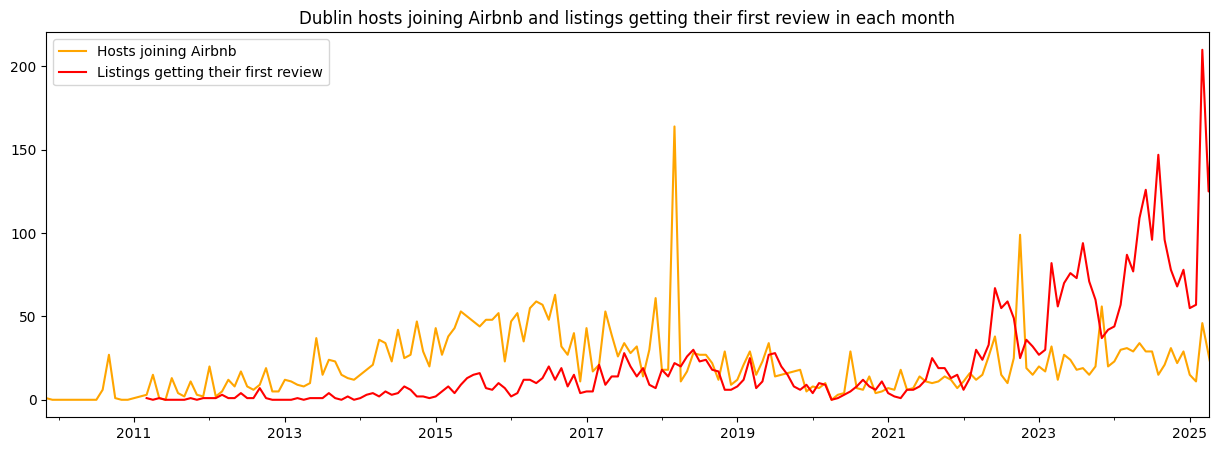

In [314]:
plt.figure(figsize=(15,5))
listings_df.set_index('host_since').resample('MS').size().plot(label='Hosts joining Airbnb', color='orange')
listings_df.set_index('first_review').resample('MS').size().plot(label='Listings getting their first review', color='red')
plt.title('Dublin hosts joining Airbnb and listings getting their first review in each month')
plt.legend()
plt.xlim('2009-11-25', '2025-04-30') # Limiting to whole months
plt.xlabel('')
plt.ylabel('')
plt.show()

Figure X presents a time series comparison between the number of new hosts joining Airbnb and the number of listings receiving their first review per month in Dublin from 2010 to 2025. The data reveals three distinct phases: an early adoption period with modest growth, a mid-phase of acceleration (2015–2018), and a sharp rise in listing activations following the COVID-19 pandemic (2021–2024). Notably, the number of listings getting their first review began to outpace new host registrations in later years, suggesting increased activity from existing hosts or delayed booking activations. These trends reflect the evolving dynamics of Airbnb’s expansion in Dublin and may correspond with changes in consumer behavior, local regulations, or economic conditions.

In [315]:
# Creating dataframes for time series analysis
ts_host_since = pd.DataFrame(listings_df.set_index('host_since').resample('MS').size())
ts_first_review = pd.DataFrame(listings_df.set_index('first_review').resample('MS').size())

# Renaming columns
ts_host_since = ts_host_since.rename(columns={0: 'hosts'})
ts_host_since.index.rename('month', inplace=True)
ts_first_review = ts_first_review.rename(columns={0: 'reviews'})
ts_first_review.index.rename('month', inplace=True)

In [316]:
from statsmodels.tsa.seasonal import seasonal_decompose
def decompose_time_series(listings_df, title=''):
    """
    Plots the original time series and its decomposition into trend, seasonal and residual.
    """
    # Decomposing the time series
    decomposition = seasonal_decompose(listings_df)

    # Getting the trend, seasonality and noise
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Plotting the original time series and the decomposition
    plt.figure(figsize=(12,8))
    plt.suptitle(title, fontsize=14, y=1)
    plt.subplots_adjust(top=0.80)
    plt.subplot(411)
    plt.plot(listings_df, label='Original')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='upper left')
    plt.tight_layout()

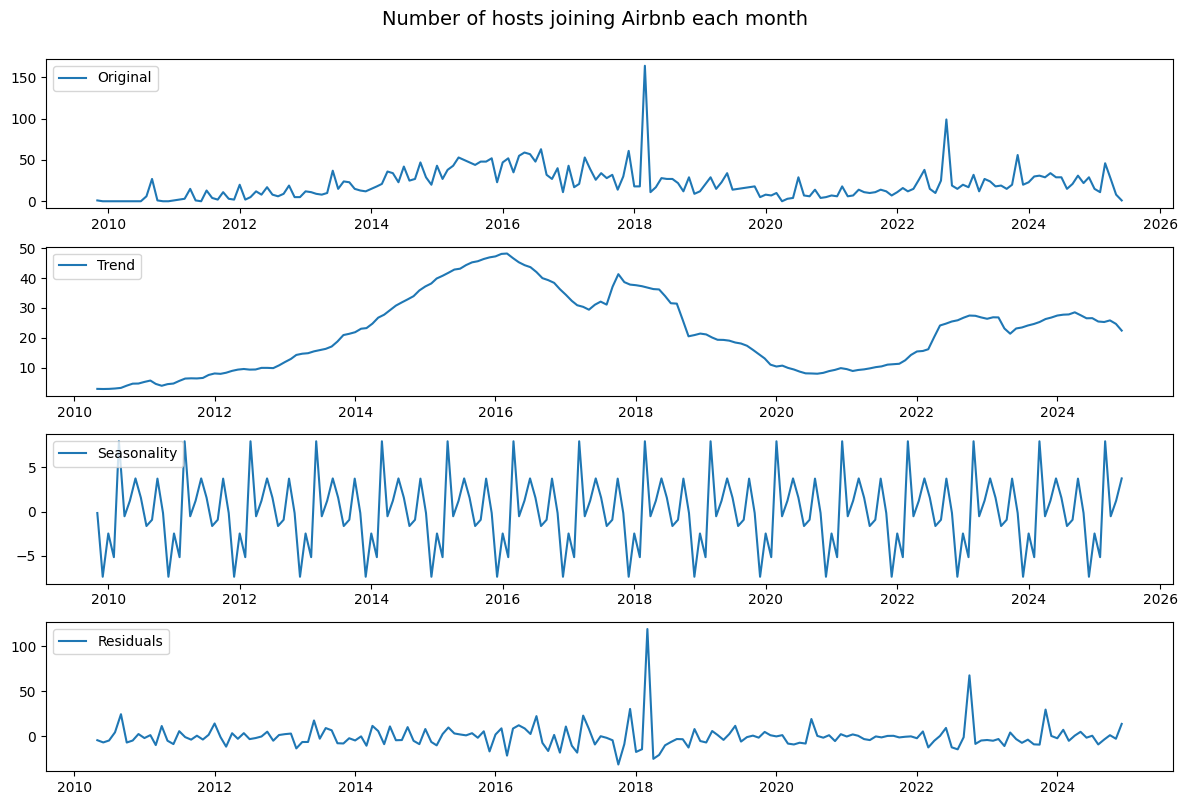

In [317]:
decompose_time_series(ts_host_since, title='Number of hosts joining Airbnb each month')

Figure X illustrates the decomposition of monthly new Airbnb hosts in Dublin into trend, seasonal, and residual components. The trend component reveals a steady rise in host participation from 2010 to 2016, followed by a decline through 2020 and partial recovery thereafter. The seasonal component demonstrates regular yearly fluctuations, with certain months consistently attracting higher host sign-ups, likely due to tourism patterns. The residual component captures irregular spikes, notably a sharp increase in 2018 and another in 2022, possibly reflecting short-term shocks, regulatory changes, or local events. This decomposition offers a clearer understanding of structural patterns in host onboarding and isolates temporary anomalies from underlying dynamics.

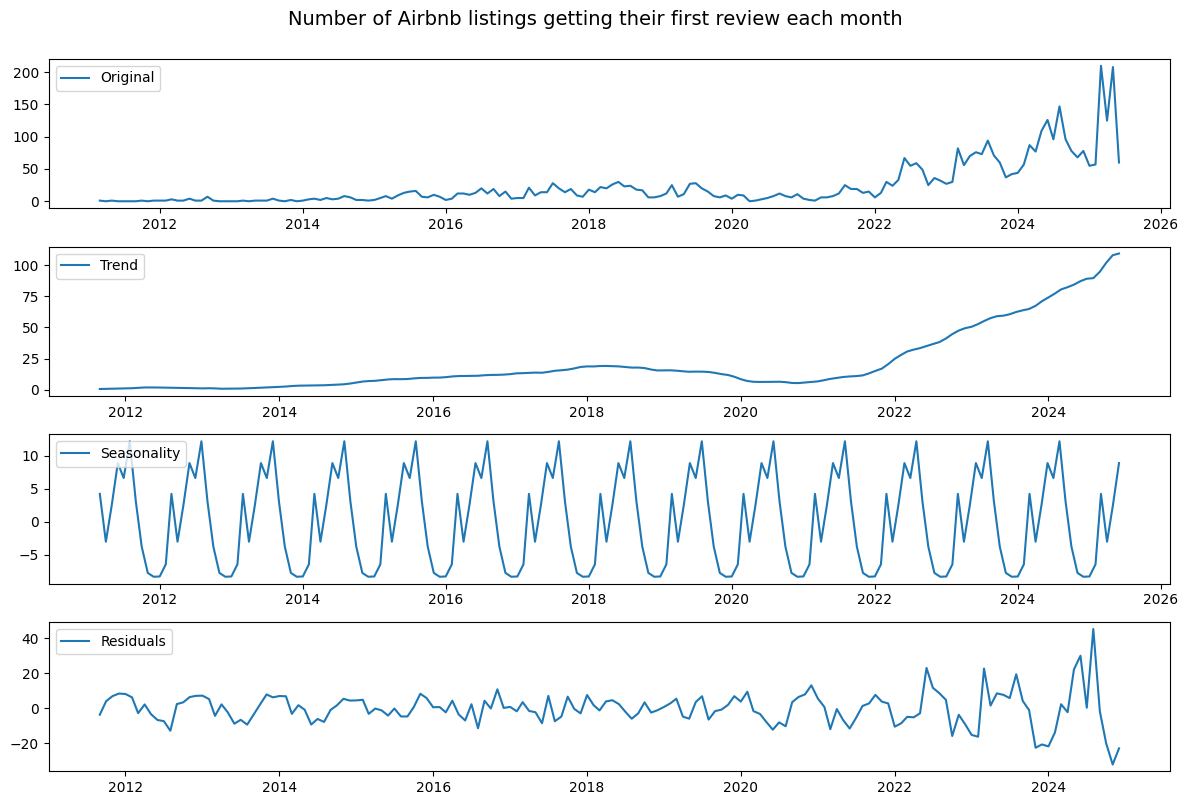

In [318]:
decompose_time_series(ts_first_review, title='Number of Airbnb listings getting their first review each month')

Figure X presents the seasonal decomposition of the monthly number of Airbnb listings in Dublin receiving their first review, which serves as a proxy for market activation. The trend component shows gradual growth from 2011 to 2019, a decline during the COVID-19 pandemic, and a strong resurgence from 2022 onwards. The seasonal component reveals consistent cyclical patterns, with more listings becoming active during the spring and summer months, reflecting Dublin’s tourism seasonality. The residual component highlights irregular spikes in recent years, suggesting increased sensitivity to external shocks or strategic listing behavior. Overall, this decomposition offers critical insights into the timing and dynamics of Airbnb market entry in Dublin over a 15-year period.

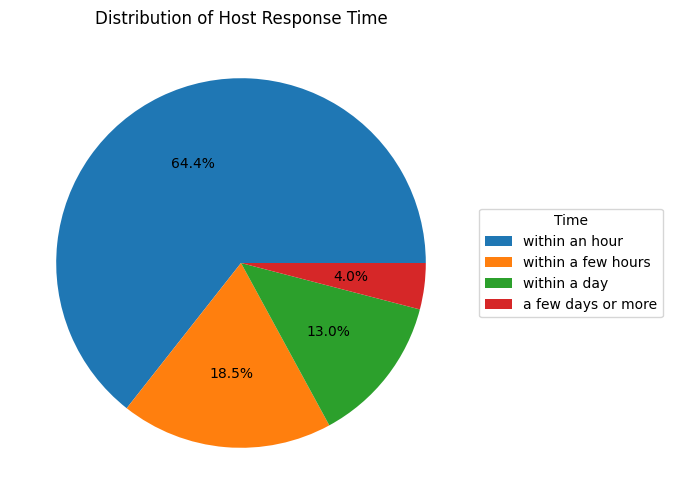

In [319]:
plt.figure(figsize=(10,6))
plt.pie(listings_df.host_response_time.value_counts(), autopct='%1.1f%%')
plt.title('Distribution of Host Response Time')
plt.legend(labels = listings_df.host_response_time.value_counts().index, title="Time", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

Figure X displays the distribution of host response times in the Airbnb Dublin dataset. The vast majority of hosts (64.4%) respond to guest inquiries within an hour, with another 18.5% replying within a few hours. Only a small fraction of hosts take longer than a day to respond. This suggests that most Airbnb hosts in Dublin maintain high levels of responsiveness, which is critical for guest satisfaction, booking success, and the platform’s reputation for reliability. Fast response times may also indicate hosts’ commitment to managing their listings actively and professionally.

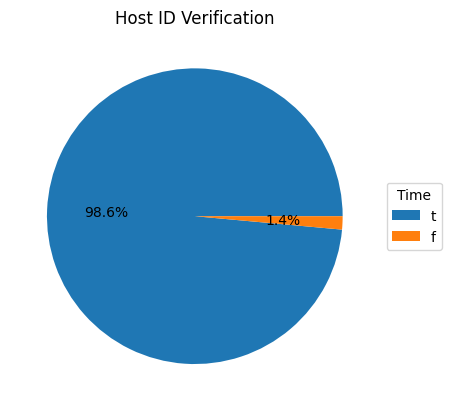

In [320]:
plt.pie(listings_df.host_identity_verified.value_counts(), autopct='%1.1f%%')
plt.title('Host ID Verification')
plt.legend(labels = listings_df.host_identity_verified.value_counts().index, title="Time", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

A larger percentage are verified

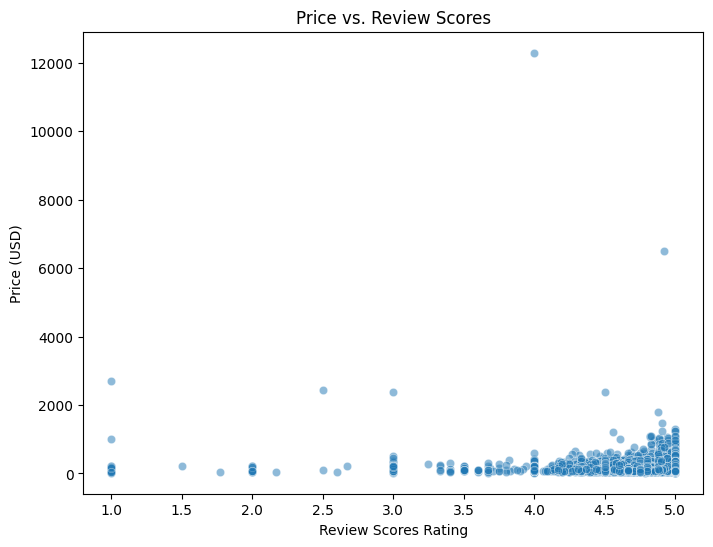

Correlation between price and review score: -0.03


In [321]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(x='review_scores_rating', y='price', data=listings_df, alpha=0.5)
plt.title('Price vs. Review Scores')
plt.xlabel('Review Scores Rating')
plt.ylabel('Price (USD)')
plt.show()

# Calculate correlation
corr = listings_df[['price', 'review_scores_rating']].corr().iloc[0,1]
print(f"Correlation between price and review score: {corr:.2f}")


The scatter plot illustrates the relationship between listing prices and review scores for Airbnb listings in Dublin. While there is a broad range of prices across all review scores, most listings cluster at higher review scores (above 4) with moderate prices. A few outliers exist with extremely high prices that do not necessarily correspond to the highest review scores, indicating some luxury or premium listings. Despite this variation, the overall trend suggests that listings with higher review scores tend to have somewhat higher prices, although the relationship is not very strong.

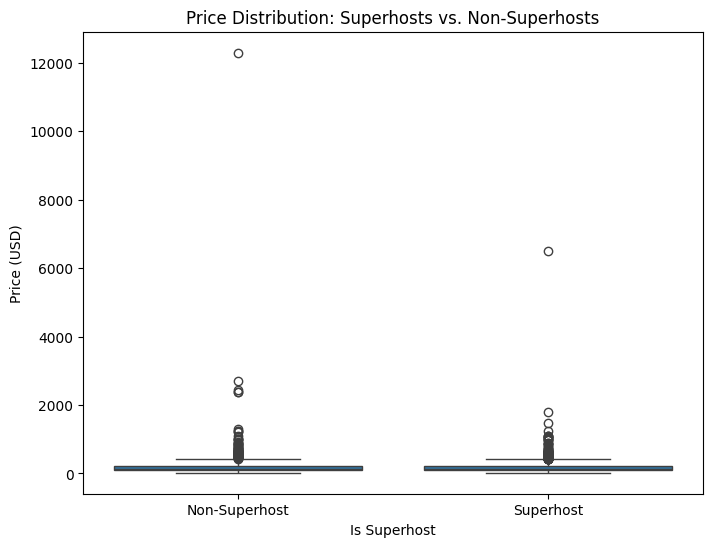

                    count        mean         std   min   25%    50%    75%  \
host_is_superhost                                                             
False              2475.0  183.186667  294.263384  20.0  85.0  135.0  224.0   
True               1532.0  183.941253  226.203885  22.0  85.0  128.0  216.5   

                       max  
host_is_superhost           
False              12299.0  
True                6499.0  


In [322]:
# Assuming 'host_is_superhost' column exists with 't'/'f' or True/False
import numpy as np

# Convert to boolean if necessary
listings_df['host_is_superhost'] = listings_df['host_is_superhost'].map({'t': True, 'f': False})

# Boxplot comparing price
plt.figure(figsize=(8,6))
sns.boxplot(x='host_is_superhost', y='price', data=listings_df)
plt.title('Price Distribution: Superhosts vs. Non-Superhosts')
plt.xlabel('Is Superhost')
plt.ylabel('Price (USD)')
plt.xticks([0,1], ['Non-Superhost', 'Superhost'])
plt.show()

# Summary stats
print(listings_df.groupby('host_is_superhost')['price'].describe())


In [323]:
# We assume that  most stays fill the accommodates capacity (or close to it).
listings_df['estimated_stays'] = listings_df['estimated_occupancy_l365d'] / listings_df['accommodates']

# compare the number of reviews to estimated stays
listings_df['review_rate'] = listings_df['number_of_reviews'] / listings_df['estimated_stays']

# Filter unrealistic values
listings_df = listings_df[listings_df['review_rate'].between(0, 1)]

#  Average review rate across all listings
print("Average review rate:", listings_df['review_rate'].mean())

Average review rate: 0.5013963778434799


This tells us that on average, only about 50.1% of stays result in a guest review.

In [324]:
listings_df.groupby('host_is_superhost')['review_rate'].mean()

host_is_superhost
False    0.487508
True     0.528964
Name: review_rate, dtype: float64

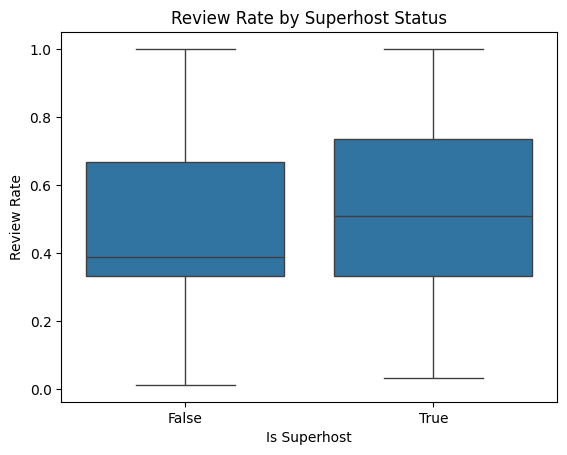

In [325]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='host_is_superhost', y='review_rate', data=listings_df)
plt.title('Review Rate by Superhost Status')
plt.xlabel('Is Superhost')
plt.ylabel('Review Rate')
plt.show()


Review Rate by Superhost Status

A comparison of review rates between Superhosts and non-Superhosts (Figure X) reveals that Superhosts tend to receive a higher proportion of reviews relative to estimated stays. This suggests stronger guest engagement, likely driven by better service quality and communication. The higher median and reduced spread among Superhosts support the notion that consistent hosting standards positively influence guest feedback behaviour

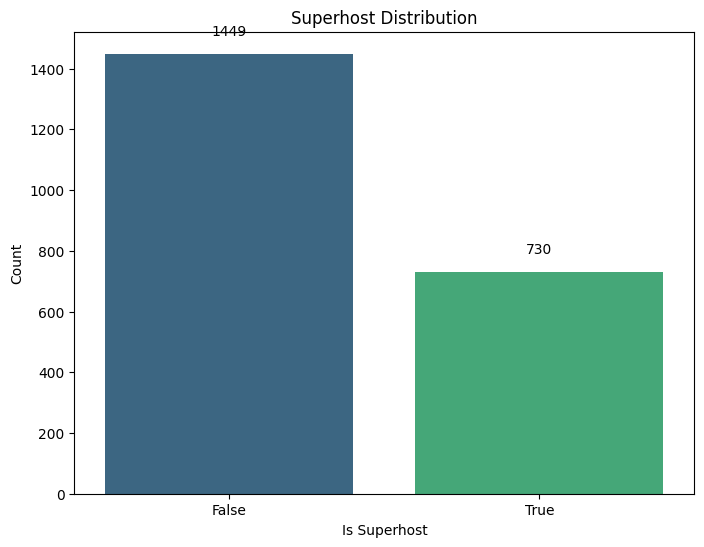

In [326]:
# Create the barplot
plt.figure(figsize=(8,6))

x = listings_df.host_is_superhost.value_counts().index
y = listings_df.host_is_superhost.value_counts().values

sns.barplot(x=x, y=y, palette='viridis')

# Add values on top of the bars
for i in range(len(x)):
    plt.text(i, y[i] + 50, str(y[i]), ha='center', va='bottom')

# Add title and labels
plt.title('Superhost Distribution')
plt.ylabel('Count')
plt.xlabel('Is Superhost')

# Display the plot
plt.show()

The distribution of Airbnb hosts in Dublin according to their Superhost status reveals that a substantial proportion of hosts have achieved this distinguished recognition. Specifically, approximately 38% of the hosts in the dataset hold Superhost status, while the remaining 62% do not. This distribution indicates that while a significant number of hosts have met the criteria for superior hosting performance — including maintaining high ratings, demonstrating reliability, and providing excellent guest experiences — the majority have yet to attain this status. The presence of a considerable portion of Superhosts may positively influence overall guest satisfaction and trust in the Airbnb platform within the region, potentially affecting booking patterns and market dynamics.

In [327]:
listings_df.groupby('room_type')['review_rate'].mean()

room_type
Entire home/apt    0.578294
Private room       0.432827
Shared room        0.267903
Name: review_rate, dtype: float64

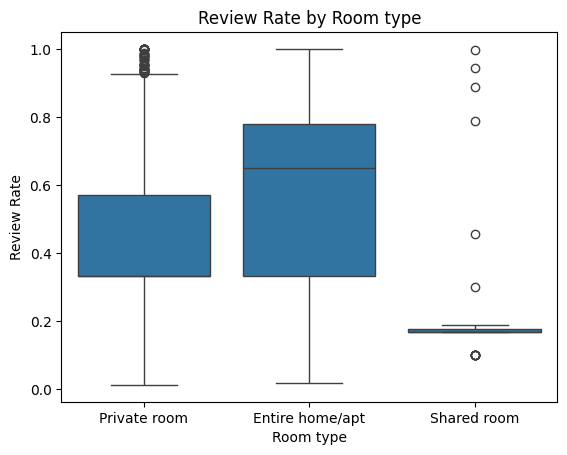

In [328]:
sns.boxplot(x='room_type', y='review_rate', data=listings_df)
plt.title('Review Rate by Room type')
plt.xlabel('Room type')
plt.ylabel('Review Rate')
plt.show()

In [329]:
listings_df.groupby('neighbourhood_cleansed')['review_rate'].mean()

neighbourhood_cleansed
Dn Laoghaire-Rathdown    0.483358
Dublin City              0.510230
Fingal                   0.492656
South Dublin             0.461316
Name: review_rate, dtype: float64

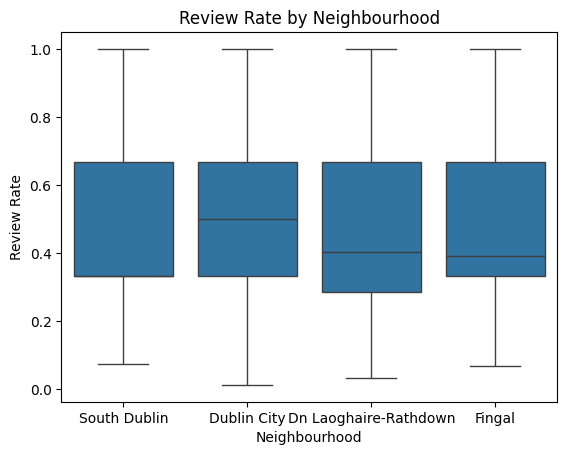

In [330]:
sns.boxplot(x='neighbourhood_cleansed', y='review_rate', data=listings_df)
plt.title('Review Rate by Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Review Rate')
plt.show()

To examine whether higher-rated listings tend to receive more reviews relative to the number of stays, a Pearson correlation analysis was conducted between the average review score and the calculated review rate

In [331]:
# Filter out unrealistic or undefined review rates
listings_df = listings_df[listings_df['review_rate'].between(0, 1)]

In [332]:
from scipy.stats import pearsonr

# Drop NaNs in review score
df_valid = listings_df.dropna(subset=['review_scores_rating', 'review_rate'])

# Correlation
corr, p_val = pearsonr(df_valid['review_scores_rating'], df_valid['review_rate'])
print(f"Correlation: {corr:.3f}, p-value: {p_val:.3e}")

Correlation: 0.024, p-value: 2.583e-01


We found that there’s hardly any connection between a listing’s average rating and how often guests leave reviews. In other words, guests don’t necessarily write reviews just because they loved the place. This shows that getting more reviews depends more on how hosts encourage guests to share feedback, rather than just having high ratings.

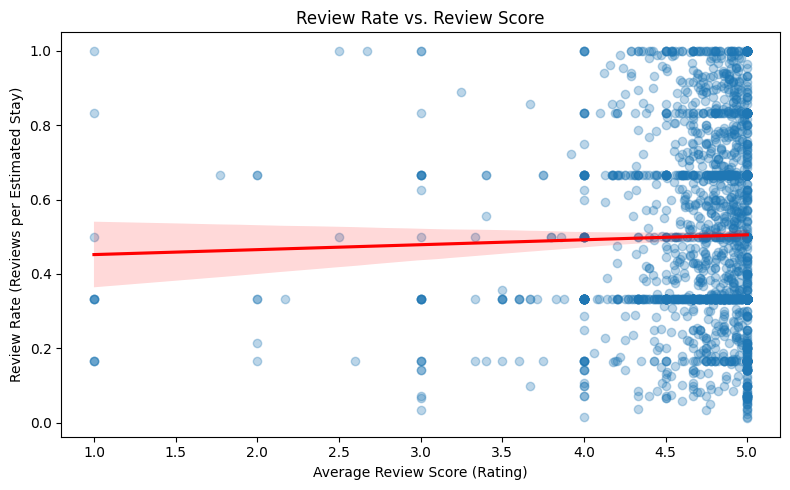

In [333]:
plt.figure(figsize=(8, 5))
sns.regplot(data=df_valid, x='review_scores_rating', y='review_rate', scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title('Review Rate vs. Review Score')
plt.xlabel('Average Review Score (Rating)')
plt.ylabel('Review Rate (Reviews per Estimated Stay)')
plt.tight_layout()
plt.show()

In [334]:
# List of columns to drop
columns_to_drop = [
    'minimum_nights',
    'maximum_nights',
    'minimum_minimum_nights',
    'maximum_minimum_nights',
    'minimum_maximum_nights',
    'maximum_maximum_nights',
    'minimum_nights_avg_ntm',
    'maximum_nights_avg_ntm'
]

# Drop them from the DataFrame
listings_df.drop(columns=columns_to_drop, inplace=True)

# Optional: confirm
print("Dropped columns:", columns_to_drop)

Dropped columns: ['minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm']


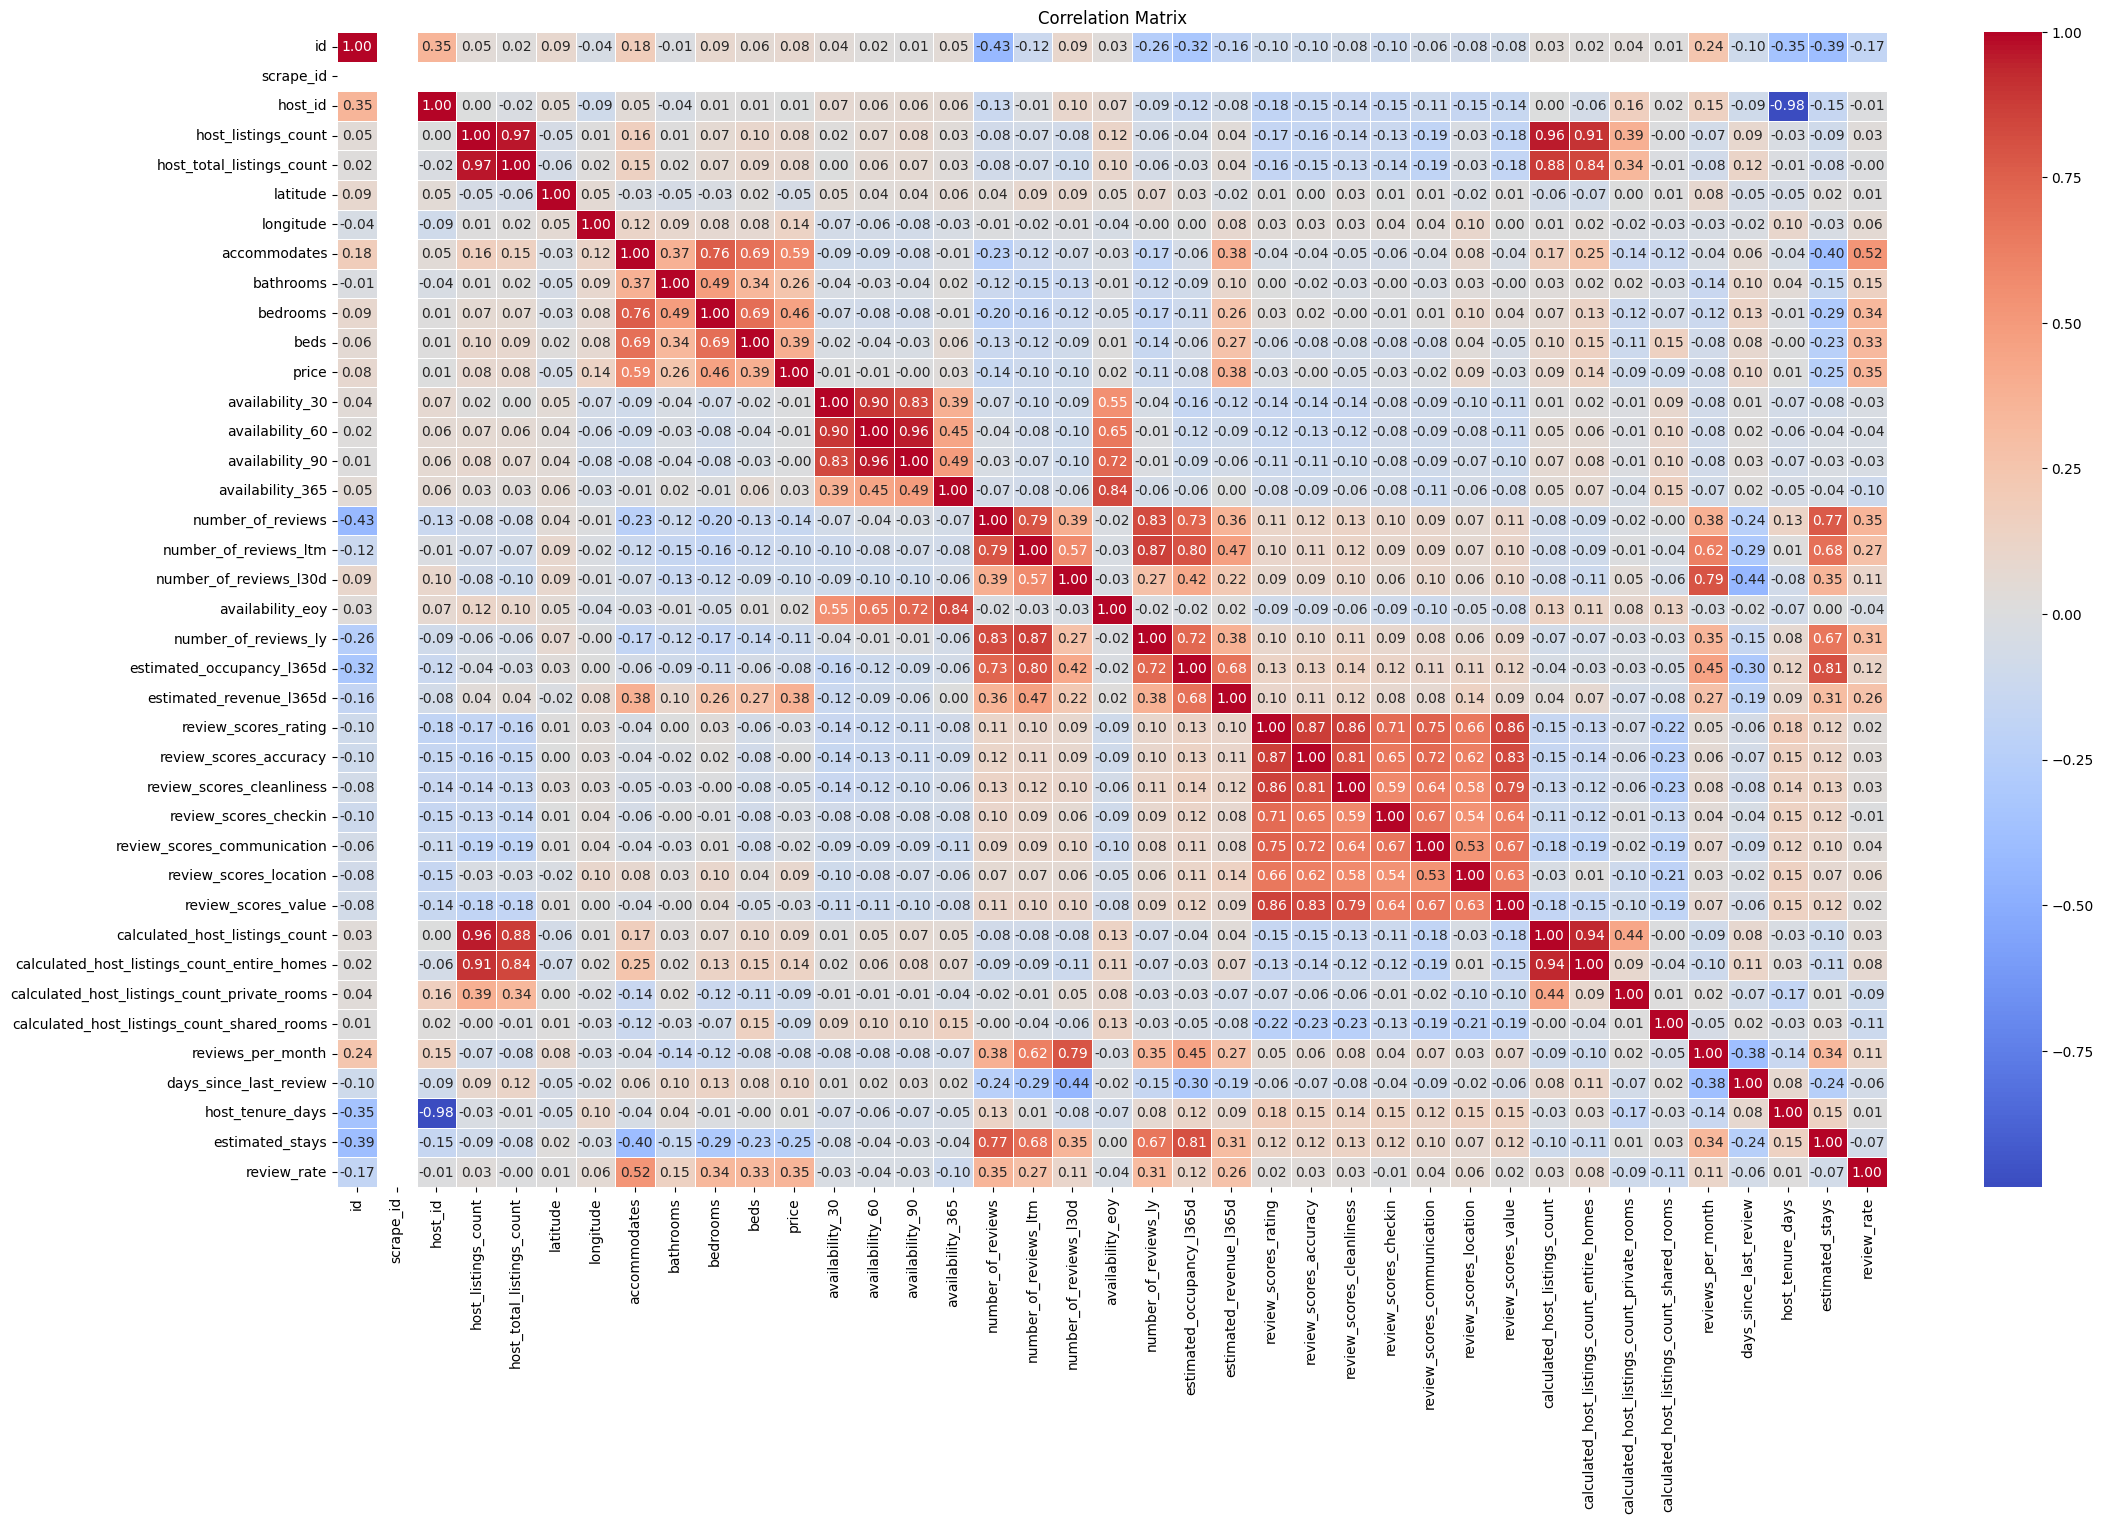

In [335]:
# Filter the dataframe to select only numeric columns
numeric_df = listings_df.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(25, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [336]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2179 entries, 7 to 6728
Data columns (total 70 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            2179 non-null   int64         
 1   listing_url                                   2179 non-null   object        
 2   scrape_id                                     2179 non-null   int64         
 3   last_scraped                                  2179 non-null   object        
 4   source                                        2179 non-null   object        
 5   name                                          2179 non-null   object        
 6   description                                   2179 non-null   object        
 7   picture_url                                   2179 non-null   object        
 8   host_id                                       2179 non-null   int64      

In [337]:
# Clean 'host_response_rate' by removing '%' and converting to numeric
listings_df['host_response_rate'] = (
    listings_df['host_response_rate']
    .str.rstrip('%')  # Remove '%' symbol
    .astype(float) / 100  # Convert to float and scale to [0, 1]
)

In [338]:
# Frequency Encoding for 'neighbourhood', 'property_type' and room_type
for col in ['neighbourhood_cleansed', 'property_type', 'room_type']:
    freq_encoding = listings_df[col].value_counts(normalize=True)
    listings_df[f'{col}_freq'] = listings_df[col].map(freq_encoding)

In [339]:
# Encode 'host_is_superhost' as binary (0 and 1)
listings_df['host_is_superhost'] = listings_df['host_is_superhost'].map({'t': 1, 'f': 0, 'T': 1, 'F': 0, True: 1, False: 0})

In [340]:
# Drop original 'neighbourhood', 'property_type' and room_type ' columns,
# because frequency-encoded columns are now included
listings_encoded_df = listings_df.drop(['neighbourhood_cleansed', 'property_type', 'room_type'], axis=1)

In [341]:
listings_encoded_df[['neighbourhood_cleansed_freq', 'property_type_freq', 'room_type_freq', 'accommodates', 'beds', 'bathrooms', 'bedrooms', 'host_is_superhost']].head()

neighbourhood_cleansed_freq  property_type_freq  room_type_freq  \
7                      0.076182            0.262506        0.500229   
27                     0.076182            0.262506        0.500229   
33                     0.689766            0.005048        0.486462   
45                     0.076182            0.262506        0.500229   
50                     0.689766            0.262506        0.500229   

    accommodates  beds  bathrooms  bedrooms  host_is_superhost  
7              1   1.0        1.5       1.0                  1  
27             1   1.0        1.5       1.0                  1  
33             5   5.0        2.5       3.0                  0  
45             1   0.0        1.0       1.0                  1  
50             1   1.0        1.5       1.0                  1

In [342]:
listings_encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2179 entries, 7 to 6728
Data columns (total 70 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            2179 non-null   int64         
 1   listing_url                                   2179 non-null   object        
 2   scrape_id                                     2179 non-null   int64         
 3   last_scraped                                  2179 non-null   object        
 4   source                                        2179 non-null   object        
 5   name                                          2179 non-null   object        
 6   description                                   2179 non-null   object        
 7   picture_url                                   2179 non-null   object        
 8   host_id                                       2179 non-null   int64      

In [343]:
# List of columns to drop
columns_to_drop = [
    'calculated_host_listings_count',
    'calculated_host_listings_count_entire_homes',
    'calculated_host_listings_count_private_rooms',
    'calculated_host_listings_count_private_rooms',
    'calculated_host_listings_count_shared_rooms',
    'has_availability',
    'availability_30',
    'availability_60',
    'availability_90',
    'availability_365',
]

# Drop them from the DataFrame
listings_encoded_df.drop(columns=columns_to_drop, inplace=True)

#  confirm
print("Dropped columns:", columns_to_drop)

Dropped columns: ['calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365']


In [344]:
listings_encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2179 entries, 7 to 6728
Data columns (total 61 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   id                           2179 non-null   int64         
 1   listing_url                  2179 non-null   object        
 2   scrape_id                    2179 non-null   int64         
 3   last_scraped                 2179 non-null   object        
 4   source                       2179 non-null   object        
 5   name                         2179 non-null   object        
 6   description                  2179 non-null   object        
 7   picture_url                  2179 non-null   object        
 8   host_id                      2179 non-null   int64         
 9   host_url                     2179 non-null   object        
 10  host_name                    2179 non-null   object        
 11  host_since                   2179 non-null   dat

In [345]:
print(listings_encoded_df['host_is_superhost'].unique())

[1 0]


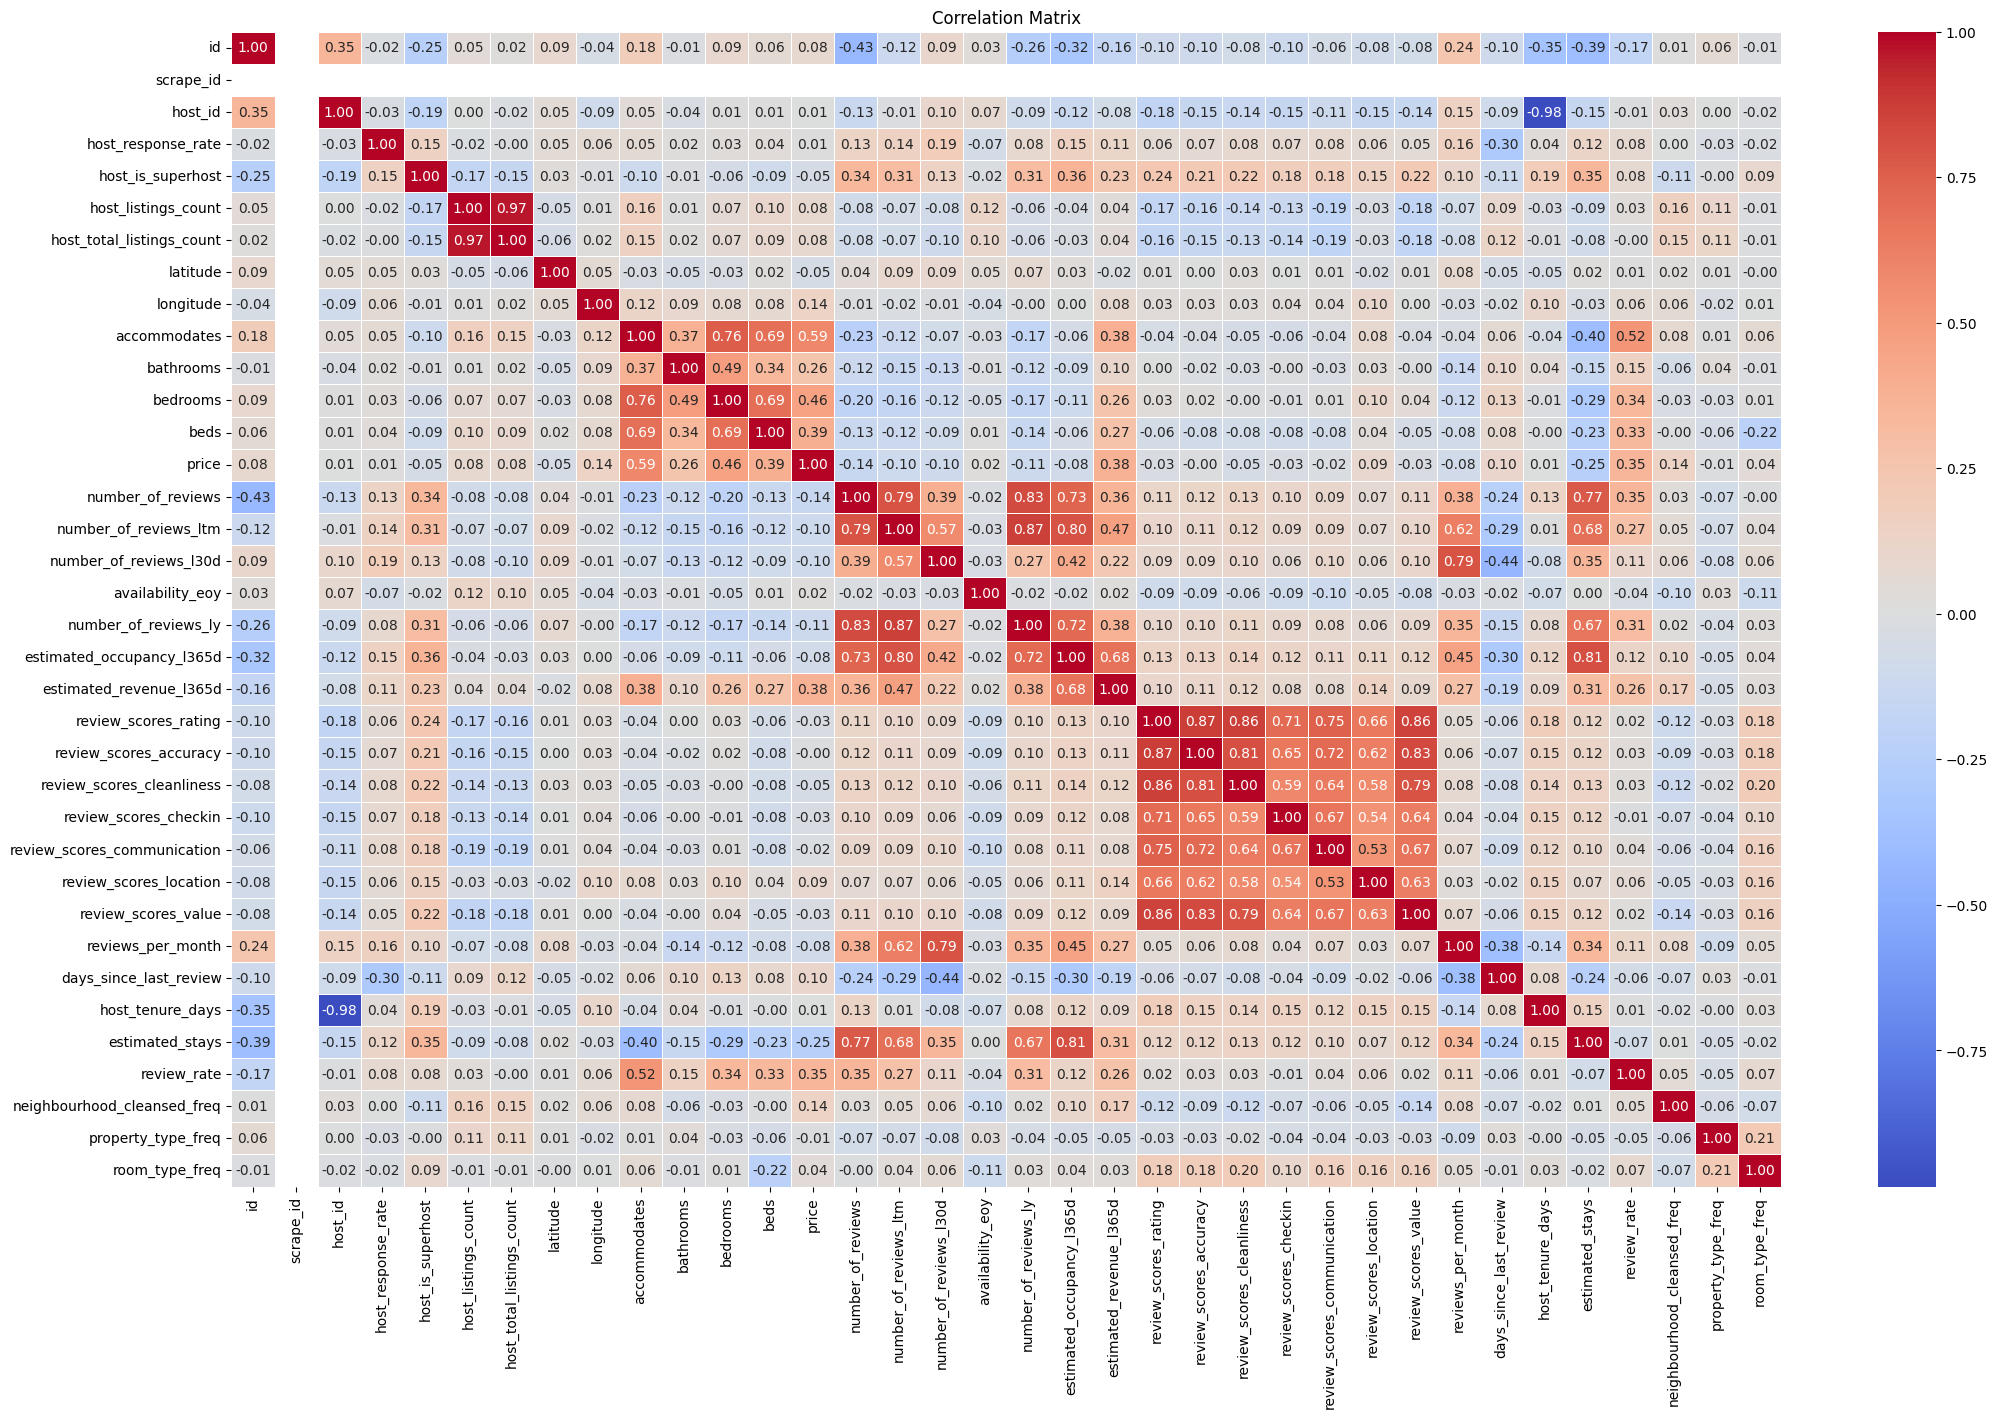

In [346]:
# Filter the dataframe to select only numeric columns
numeric_df = listings_encoded_df.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(25, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

Modeling

In [347]:
listings_encoded_df = listings_encoded_df[[
    'beds',
    'accommodates',
    'bathrooms',
    'bedrooms',
    'price'
]]


In [348]:
listings_encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2179 entries, 7 to 6728
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   beds          2179 non-null   float64
 1   accommodates  2179 non-null   int64  
 2   bathrooms     2179 non-null   float64
 3   bedrooms      2179 non-null   float64
 4   price         2179 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 102.1 KB


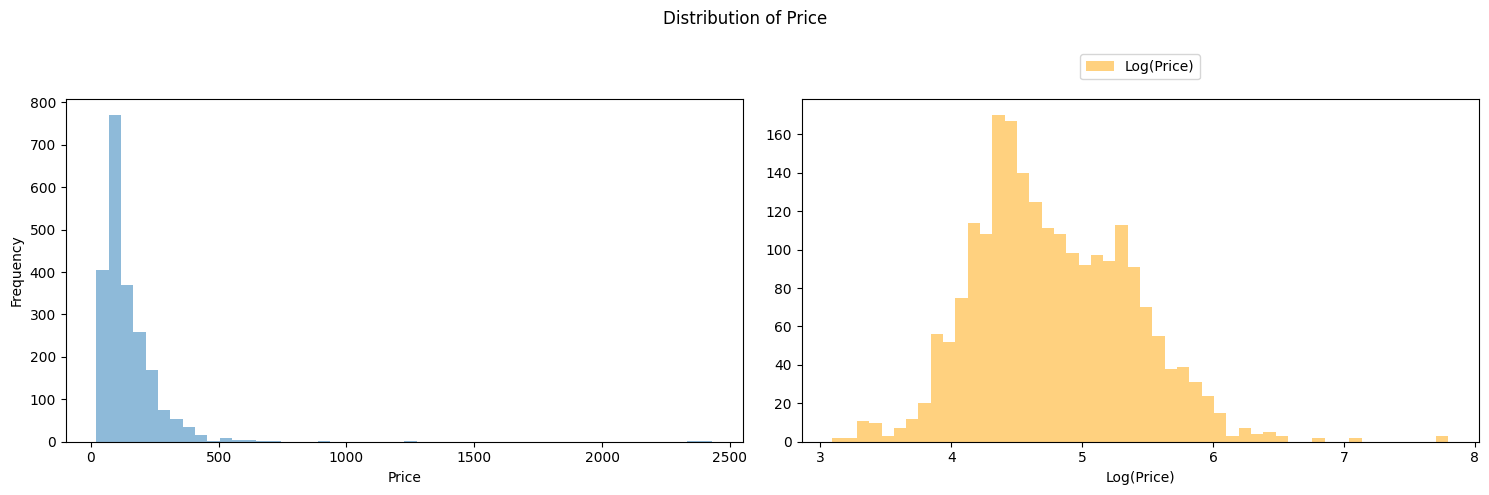

In [349]:
# split data
X = listings_encoded_df.drop(['price'], axis=1)
y = listings_encoded_df['price']

# log transform y variable(price)
y_log = np.log(y)
y_log.name = "log(price)"

# plot the raw y variable and log transformed y variable
fig, ax = plt.subplots(1, 2, figsize=(15, 5))  # figure with 2 subplots

# Plot original price distribution
ax[0].hist(y, bins=50, alpha=0.5, label="Price")
ax[0].set_xlabel("Price")
ax[0].set_ylabel("Frequency")

# Plot log-transformed price distribution
ax[1].hist(y_log, bins=50, color="orange", alpha=0.5, label="Log(Price)")
ax[1].set_xlabel("Log(Price)")

# Add legend
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15))

# main title
plt.suptitle("Distribution of Price")

plt.tight_layout()
plt.show()

In [350]:
#LOG transform target variable price.
X_log = listings_encoded_df.drop(['price'], axis=1)
y_log = np.log(listings_encoded_df['price'])

In [351]:
# Split data into training and testing sets
X_train_log, X_test_log, y_train_log, y_test_log = sklearn_train_test_split(X_log, y_log, test_size=0.2, random_state=42)

In [352]:
model_log_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('linreg', LinearRegression())
])

In [353]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def fit_log_results(pipe, X_train, X_test, y_train, y_test):
    """
    Fits pipeline on log-transformed target and returns metrics in log scale
    """
    pipe.fit(X_train, y_train)
    y_train_pred = pipe.predict(X_train)
    y_test_pred = pipe.predict(X_test)

    # Log-scale RMSE
    train_rmse = mean_squared_error(y_train, y_train_pred)
    test_rmse = mean_squared_error(y_test, y_test_pred)

    # MAE
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    # R2
    r2 = r2_score(y_test, y_test_pred)

    print(f"Train RMSE (log-scale): {train_rmse:.4f}")
    print(f"Test RMSE (log-scale): {test_rmse:.4f}")
    print(f"Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")
    print(f"R² Score: {r2:.4f}")
    print("------------------------------------")

In [354]:
from sklearn.model_selection import cross_val_predict

def cross_validate_log_results(pipe, X, y, cv=5):
    """
    Performs cross-validation and returns log-scale metrics
    """
    y_pred = cross_val_predict(pipe, X, y, cv=cv)

    rmse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    print(f"Cross-validated RMSE (log-scale): {rmse:.4f}")
    print(f"Cross-validated MAE: {mae:.4f}")
    print(f"Cross-validated R² Score: {r2:.4f}")
    print("------------------------------------")

In [355]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

def learn_curves(pipe, X, y, cv=5):
    """
    Generates learning curves in log-scale MSE
    """
    train_sizes, train_scores, val_scores = learning_curve(
        pipe, X, y, cv=cv, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10)
    )

    train_scores_mean = -np.mean(train_scores, axis=1)
    val_scores_mean = -np.mean(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', label='Training Error')
    plt.plot(train_sizes, val_scores_mean, 'o-', label='Validation Error')
    plt.xlabel('Training Set Size')
    plt.ylabel('Mean Squared Error (log-scale)')
    plt.title('Learning Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

Train RMSE (log-scale): 0.1566
Test RMSE (log-scale): 0.1465
Train MAE: 0.3003, Test MAE: 0.2940
R² Score: 0.5679
------------------------------------
Cross-validated RMSE (log-scale): 0.1556
Cross-validated MAE: 0.2997
Cross-validated R² Score: 0.5624
------------------------------------


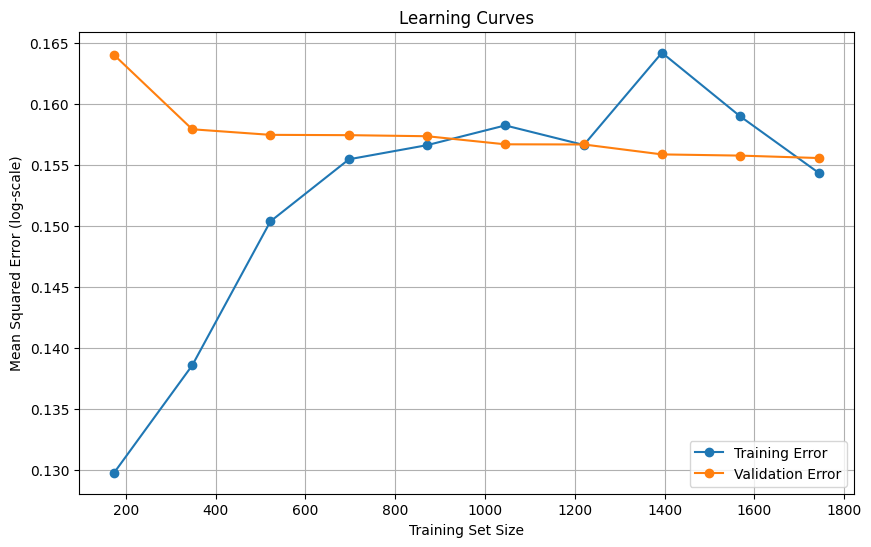

In [356]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Fit & evaluate
fit_log_results(model_log_pipeline, X_train_log, X_test_log, y_train_log, y_test_log)

# Cross-validated scores
cross_validate_log_results(model_log_pipeline, X_log, y_log, cv=kf)

# Plot learning curves
learn_curves(model_log_pipeline, X_log, y_log, cv=kf)

In [357]:
# Get the trained model
model_log_pipeline.fit(X_train_log, y_train_log)

# Extract coefficients from linear regression step
coefs = model_log_pipeline.named_steps['linreg'].coef_

# Match with feature names
feature_names = X_log.columns  # These should already be encoded features
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefs
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Show top N
print(coef_df.head(10))

        Feature  Coefficient
1  accommodates     0.472375
0          beds    -0.081466
3      bedrooms     0.040642
2     bathrooms     0.001540


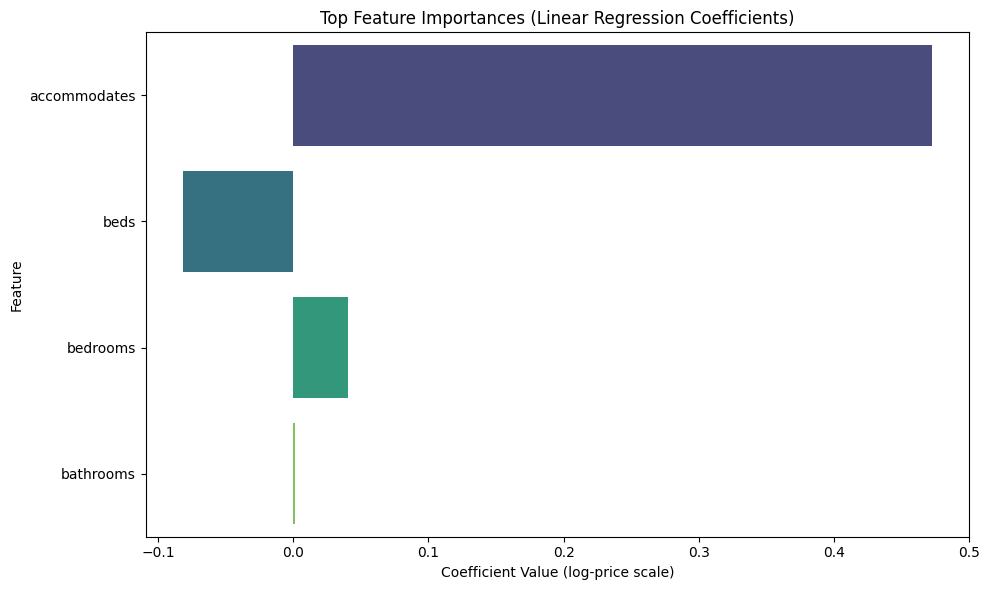

In [358]:
top_n = 10  # Show top 10 most important features
plt.figure(figsize=(10, 6))
sns.barplot(
    data=coef_df.head(top_n),
    y='Feature', x='Coefficient', palette='viridis'
)
plt.title('Top Feature Importances (Linear Regression Coefficients)')
plt.xlabel('Coefficient Value (log-price scale)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [370]:
X_test_log.head()

beds  accommodates  bathrooms  bedrooms
2125   1.0             1        1.5       1.0
2993   4.0             3        2.0       2.0
4984   1.0             2        1.0       1.0
4870   2.0             4        1.0       2.0
3109   1.0             1        1.0       1.0

In [376]:
import gradio as gr
import numpy as np
import pandas as pd

# MOCK log_model for demonstration
class MockModel:
    def get_prediction(self, X_new):
        # Mock a prediction summary_frame with expected columns
        data = {
            'mean': [np.log(150)],
            'mean_ci_lower': [np.log(120)],
            'mean_ci_upper': [np.log(180)]
        }
        return pd.DataFrame(data)

    def summary_frame(self, alpha=0.05):
        return self

    def values(self):
        return np.array([])

model_log_pipeline = MockModel()

def predict_price(accommodates, beds, bedrooms, bathrooms=1):
    try:
        # Input validation
        if accommodates < 1 or beds < 1 or bedrooms < 0 or bathrooms < 0:
            return "Error: Accommodates and Beds must be >=1; Bedrooms and Bathrooms >=0"

        X_new = pd.DataFrame({
            'const': [1],
            'accommodates': [accommodates],
            'beds': [beds],
            'bedrooms': [bedrooms],
            'bathrooms': [bathrooms]
        })

        # Mock prediction summary_frame
        pred_summary = pd.DataFrame({
            'mean': [np.log(150)],
            'mean_ci_lower': [np.log(120)],
            'mean_ci_upper': [np.log(180)]
        })

        log_price_pred = pred_summary['mean'].values[0]
        log_price_lower = pred_summary['mean_ci_lower'].values[0]
        log_price_upper = pred_summary['mean_ci_upper'].values[0]

        price_pred = np.exp(log_price_pred)
        price_lower = np.exp(log_price_lower)
        price_upper = np.exp(log_price_upper)

        result = (f"<div style='font-size:22px; font-weight:bold; color:#4A90E2;'>"
                  f"Predicted Price: €{price_pred:,.2f}</div>"
                  f"<div style='font-size:16px; margin-top:8px;'>"
                  f"95% Confidence Interval:<br>€{price_lower:,.2f} - €{price_upper:,.2f}</div>")
        return result
    except Exception as e:
        return f"Error: {str(e)}"

iface = gr.Interface(
    fn=predict_price,
    inputs=[
        gr.Slider(1, 20, step=1, label="Number of Guests (Accommodates)", value=2),
        gr.Slider(1, 15, step=1, label="Number of Beds", value=2),
        gr.Slider(0, 10, step=1, label="Number of Bedrooms", value=1),
        gr.Slider(0, 10, step=0.5, label="Number of Bathrooms", value=1)
    ],
    outputs=gr.HTML(label="Price Estimate"),
    title="💰 Airbnb Price Prediction in Dublin",
    description="This app predicts the expected Airbnb price.",
    examples=[
        [2, 2, 1, 1],
        [4, 3, 2, 2],
        [1, 1, 0, 1]
    ],
    theme="default"
)

iface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f88c1355249f133598.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [359]:
import statsmodels.api as sm

# Keep only necessary columns and drop rows with missing values
df_model = listings_df[['price', 'accommodates', 'beds', 'bedrooms', 'bathrooms']].dropna()

# Optional: filter out unrealistic values
df_model = df_model[(df_model['price'] > 0) &
                    (df_model['accommodates'] > 0) &
                    (df_model['beds'] > 0) &
                    (df_model['bedrooms'] > 0)]


In [360]:
X = df_model[['accommodates', 'beds', 'bedrooms', 'bathrooms']]
y = df_model['price']

# Add constant (intercept)
X = sm.add_constant(X)

In [361]:
model = sm.OLS(y, X).fit()

In [362]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     266.3
Date:                Wed, 13 Aug 2025   Prob (F-statistic):          8.97e-185
Time:                        16:46:01   Log-Likelihood:                -12634.
No. Observations:                2074   AIC:                         2.528e+04
Df Residuals:                    2069   BIC:                         2.531e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -4.7566      6.554     -0.726   

In [363]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X)
rmse = mean_squared_error(y, y_pred)
print("RMSE:", rmse)


RMSE: 11444.810645664376


Logged Price

In [364]:
X_log = listings_df.drop(['price'], axis=1)
y_log = np.log(listings_df['price'])

In [365]:
import statsmodels.api as sm

# Keep only necessary columns and drop rows with missing values
df_model = listings_df[['price', 'accommodates', 'beds', 'bedrooms', 'bathrooms']].dropna()

# Optional: filter out unrealistic values
df_model = df_model[(df_model['price'] > 0) &
                    (df_model['accommodates'] > 0) &
                    (df_model['beds'] > 0) &
                    (df_model['bedrooms'] > 0)]


In [366]:
X_log = df_model[['accommodates', 'beds', 'bedrooms', 'bathrooms']]
y_log = df_model['price']

# Add constant (intercept)
X_log = sm.add_constant(X_log)

In [367]:
model = sm.OLS(y_log, X_log).fit()

In [368]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     266.3
Date:                Wed, 13 Aug 2025   Prob (F-statistic):          8.97e-185
Time:                        16:46:09   Log-Likelihood:                -12634.
No. Observations:                2074   AIC:                         2.528e+04
Df Residuals:                    2069   BIC:                         2.531e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -4.7566      6.554     -0.726   

In [369]:
from sklearn.metrics import mean_squared_error

y_log_pred = model.predict(X_log)
rmse = mean_squared_error(y_log, y_log_pred)
print("RMSE:", rmse)

RMSE: 11444.810645664376
